# **AI Applications Project: New Orleans Airbnb Market Analysis**

## Project Overview
This notebook contains the exploratory data analysis (EDA) for our Airbnb market analysis project focusing on New Orleans. We will analyze listings, calendar, and reviews data to gain insights into the local short-term rental market and prepare for predictive modeling.

## Data Sources
- **Listings Data**: Property information including location, amenities, and pricing
- **Calendar Data**: Daily availability and pricing information  
- **Reviews Data**: Guest feedback and ratings for sentiment analysis

---
## 📊 NOTEBOOK NAVIGATION GUIDE

**KEY VISUALIZATIONS FOR PRESENTATION & REPORT:**

**PART 1: Data Loading & Initial Exploration (Cells 2-10)**
- Cells 2-10: Dataset loading and basic inspection

**PART 2: Data Cleaning & Preprocessing (Cells 11-20)**
- **Cell 13**: Distribution-aware imputation strategy
- Cell 19: Comprehensive data profiling
- Cell 20: Categorical variable analysis

**PART 3: Exploratory Data Analysis (Cells 21-33)**
- Cells 21-23: Correlation matrices
- **Cell 29**: 📈 **CHART 1 - Price Distribution** (Presentation Slide 2)
- Cells 30-33: Geographic patterns

**PART 4: Machine Learning Pipeline (Cells 36-50)**
- Cell 37: Feature selection (21 features)
- Cell 38: Train/test split
- **Cell 43**: 📊 **CHART 2 - Model Comparison** (Presentation Slide 4)
- **Cell 45**: 📉 **CHART 3 - Prediction vs Actual** (Presentation Slide 6)
- **Cell 46**: 📊 **CHART 4 - Feature Importance** (Presentation Slide 5)
- **Cell 47**: Prediction accuracy analysis
- **Cell 48**: 📉 **CHART 5 - Residual Analysis** (Presentation Slide 6)
- **Cell 50**: Business recommendations with ROI

---

In [9]:
# Import essential libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import re

# Machine learning libraries for future use
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Configure visualization settings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Display settings for better output formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [10]:
# Data acquisition from Inside Airbnb
# New Orleans selected due to its unique tourism patterns, cultural significance, 
# and diverse neighborhood characteristics that provide rich analytical opportunities

print("Loading New Orleans Airbnb datasets...")

# Define URLs for the three main datasets
listings_url = 'https://data.insideairbnb.com/united-states/la/new-orleans/2025-09-11/data/listings.csv.gz'
calendar_url = 'https://data.insideairbnb.com/united-states/la/new-orleans/2025-09-11/data/calendar.csv.gz'
reviews_url = 'https://data.insideairbnb.com/united-states/la/new-orleans/2025-09-11/data/reviews.csv.gz'

# Load the datasets into DataFrames with compression handling
listings_df = pd.read_csv(listings_url, compression='gzip')
calendar_df = pd.read_csv(calendar_url, compression='gzip')
reviews_df = pd.read_csv(reviews_url, compression='gzip')

print(f"✓ Listings dataset loaded: {listings_df.shape[0]:,} records, {listings_df.shape[1]} columns")
print(f"✓ Calendar dataset loaded: {calendar_df.shape[0]:,} records, {calendar_df.shape[1]} columns")
print(f"✓ Reviews dataset loaded: {reviews_df.shape[0]:,} records, {reviews_df.shape[1]} columns")

Loading New Orleans Airbnb datasets...
✓ Listings dataset loaded: 7,444 records, 79 columns
✓ Calendar dataset loaded: 2,717,060 records, 7 columns
✓ Reviews dataset loaded: 489,253 records, 6 columns
✓ Listings dataset loaded: 7,444 records, 79 columns
✓ Calendar dataset loaded: 2,717,060 records, 7 columns
✓ Reviews dataset loaded: 489,253 records, 6 columns


In [11]:
# Quick check of available columns for categorical analysis
print("\nColumn Analysis for Categorical Data Integration:")
print("-" * 50)

# Check host-related columns
host_cols = [col for col in listings_df.columns if 'host' in col.lower()]
print(f"Host-related columns ({len(host_cols)}):")
for col in host_cols[:8]:  # Show first 8
    print(f"  • {col}")

# Check superhost specifically
if 'host_is_superhost' in listings_df.columns:
    superhost_values = listings_df['host_is_superhost'].value_counts()
    print(f"\nSuperhost distribution:")
    for value, count in superhost_values.items():
        print(f"  • {value}: {count:,} hosts ({count/len(listings_df)*100:.1f}%)")
else:
    print(f"\n⚠ host_is_superhost column not found")

# Check other key categorical columns
key_categorical_check = ['room_type', 'neighbourhood_cleansed', 'property_type', 'instant_bookable']
print(f"\nOther categorical columns availability:")
for col in key_categorical_check:
    if col in listings_df.columns:
        unique_count = listings_df[col].nunique()
        print(f"  ✓ {col}: {unique_count} unique values")
    else:
        print(f"  ✗ {col}: not found")

print("-" * 50)


Column Analysis for Categorical Data Integration:
--------------------------------------------------
Host-related columns (22):
  • host_id
  • host_url
  • host_name
  • host_since
  • host_location
  • host_about
  • host_response_time
  • host_response_rate

Superhost distribution:
  • f: 3,975 hosts (53.4%)
  • t: 3,201 hosts (43.0%)

Other categorical columns availability:
  ✓ room_type: 4 unique values
  ✓ neighbourhood_cleansed: 70 unique values
  ✓ property_type: 47 unique values
  ✓ instant_bookable: 2 unique values
--------------------------------------------------


In [12]:
# Display first 5 rows of listings data to understand property features
# Listings data contains property details, pricing, location, and host information
listings_df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,19091,https://www.airbnb.com/rooms/19091,20250911031349,2025-09-11,city scrape,Fully Furnished Cozy Apartment,This cozy space is a wonder of post-Katrina re...,"NorthWest Carrollton, where this apartment is ...",https://a0.muscache.com/pictures/a5fdfd3b-5d81...,72880,https://www.airbnb.com/users/show/72880,John,2010-01-23,"New Orleans, LA",I recently (2018) retired as the Director of B...,within an hour,100%,100%,f,https://a0.muscache.com/im/users/72880/profile...,https://a0.muscache.com/im/users/72880/profile...,Riverbend,1.0,1.0,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Leonidas,NaN,29.96100,-90.11950,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Hot water kettle"", ""Air conditioning"", ""Dish...",$61.00,1,365,1.0,1.0,365.0,365.0,1.0,365.0,NaN,t,23,34,61,331,2025-09-11,510,7,3,83,0,70,4270.0,2010-04-16,2025-08-31,4.89,4.95,4.87,4.97,4.98,4.68,4.91,"25-NSTR-11772, 25-OSTR-11151",f,1,1,0,0,2.72
1,71624,https://www.airbnb.com/rooms/71624,20250911031349,2025-09-11,city scrape,Ravenwood Manor (Historic Bywater),You are in for a very unique stay in a neighbo...,"Ours is a neighborhood made up of artists, mus...",https://a0.muscache.com/pictures/37488608/8cc1...,367223,https://www.airbnb.com/users/show/367223,Susan,2011-01-29,"New Orleans, LA",I am a decorative painter and faux finish arti...,NaN,NaN,70%,f,https://a0.muscache.com/im/users/367223/profil...,https://a0.muscache.com/im/users/367223/profil...,Bywater,1.0,2.0,"['email', 'phone']",t,t,Neighborhood highlights,Bywater,NaN,29.96153,-90.04364,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Host greets you"", ""Air conditioning"", ""Dishe...",$150.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,30,51,81,356,2025-09-11,316,7,0,103,19,255,38250.0,2011-02-16,2025-05-07,4.94,4.92,4.93,4.98,4.98,4.84,4.89,"21-RSTR-18609, 22-OSTR-20720",f,1,1,0,0,1.78
2,74498,https://www.airbnb.com/rooms/74498,20250911031349,2025-09-11,city scrape,Maison Marais 1,Maison Marais 1 is a stylish one-bedroom apart...,"This is a vibrant, diverse neighborhood of mos...",https://a0.muscache.com/pictures/73591836/a1f5...,391462,https://www.airbnb.com/users/show/391462,Georgia,2011-02-14,"New Orleans, LA","New Orleans enthusiast, loves to cook and eat,...",within an hour,100%,99%,t,https://a0.muscache.com/im/users/391462/profil...,https://a0.muscache.com/im/users/391462/profil...,St. Claude/St. Roch,3.0,3.0,"['email', 'phone']",t,t,Neighborhood highlights,St. Roch,NaN,29.96986,-90.05172,Entire rental unit,Entire home/apt,3,1.0,1 bath,1.0,2.0,"[""Hot water kettle"", ""Ex

In [13]:
# Examine listings dataset structure and data types
# Critical for identifying price columns that need string-to-numeric conversion
print("Listings Dataset Info:")
listings_df.info()

Listings Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7444 entries, 0 to 7443
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7444 non-null   int64  
 1   listing_url                                   7444 non-null   object 
 2   scrape_id                                     7444 non-null   int64  
 3   last_scraped                                  7444 non-null   object 
 4   source                                        7444 non-null   object 
 5   name                                          7444 non-null   object 
 6   description                                   7373 non-null   object 
 7   neighborhood_overview                         4429 non-null   object 
 8   picture_url                                   7444 non-null   object 
 9   host_id                                 

In [14]:
# Display first 5 rows of calendar data to understand structure
# Calendar data shows daily pricing and availability for each listing
calendar_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,19091,2025-09-11,t,NaN,NaN,1,365
1,19091,2025-09-12,t,NaN,NaN,1,365
2,19091,2025-09-13,f,NaN,NaN,1,365
3,19091,2025-09-14,f,NaN,NaN,1,365
4,19091,2025-09-15,t,NaN,NaN,1,365


In [15]:
# Examine calendar dataset structure and data types
# This helps identify which columns need formatting (especially price columns)
print("Calendar Dataset Info:")
calendar_df.info()

Calendar Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717060 entries, 0 to 2717059
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           float64
 4   adjusted_price  float64
 5   minimum_nights  int64  
 6   maximum_nights  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 145.1+ MB


In [16]:
# Display first 5 rows of reviews data to understand review structure
# Reviews data contains guest feedback, ratings, and comment text for sentiment analysis
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,19091,35930,2010-04-16,97343,Melissa,John was extremely accommodating to our schedu...
1,19091,45900,2010-05-24,99114,Casey,John was a great host and made sure that I cou...
2,19091,61668,2010-07-06,128406,Sherian,My husband and I stayed with John last month a...
3,19091,96538,2010-09-13,228880,Anthony,John is a great host for your time in New Orle...
4,19091,108793,2010-09-30,214223,Candace,john is a fantastic host. the place is perfe...


In [17]:
# Examine reviews dataset structure and data types
# Important to understand date formats and text column characteristics
print("Reviews Dataset Info:")
reviews_df.info()

Reviews Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489253 entries, 0 to 489252
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     489253 non-null  int64 
 1   id             489253 non-null  int64 
 2   date           489253 non-null  object
 3   reviewer_id    489253 non-null  int64 
 4   reviewer_name  489252 non-null  object
 5   comments       489100 non-null  object
dtypes: int64(3), object(3)
memory usage: 22.4+ MB


---
# 📊 PART 2: DATA CLEANING & PREPROCESSING
**Cells 11-20**
---

## Data Cleaning and Preprocessing

### Missing Value Analysis and Treatment

In [18]:
print("Missing values in listings_df:")
display(listings_df.isnull().sum()[listings_df.isnull().sum() > 0])

print("\nMissing values in calendar_df:")
display(calendar_df.isnull().sum()[calendar_df.isnull().sum() > 0])

print("\nMissing values in reviews_df:")
display(reviews_df.isnull().sum()[reviews_df.isnull().sum() > 0])

# Handle missing values in listings_df
# Drop columns with a high percentage of missing values if they exist
cols_to_drop = ['neighbourhood_group_cleansed', 'calendar_updated']
existing_cols_to_drop = [col for col in cols_to_drop if col in listings_df.columns]
if existing_cols_to_drop:
    listings_df.drop(columns=existing_cols_to_drop, inplace=True)

# Impute numerical columns: Check distribution shape and use appropriate strategy
# Use median for skewed distributions, mean for symmetric distributions
from scipy import stats

numerical_cols = listings_df.select_dtypes(include=np.number).columns
print(f"\n{'='*60}")
print("NUMERICAL IMPUTATION STRATEGY")
print("="*60)

for col in numerical_cols:
    if listings_df[col].isnull().sum() > 0:
        # Calculate skewness to determine imputation method
        skewness = listings_df[col].skew()
        
        # If |skewness| > 1, distribution is highly skewed - use median
        # If |skewness| < 1, distribution is relatively symmetric - use mean
        if abs(skewness) > 1:
            impute_value = listings_df[col].median()
            method = "median (skewed distribution)"
        else:
            impute_value = listings_df[col].mean()
            method = "mean (symmetric distribution)"
        
        listings_df[col].fillna(impute_value, inplace=True)
        print(f"{col}: Skewness={skewness:.2f} → Using {method}")

# Impute categorical columns with the mode
categorical_cols = listings_df.select_dtypes(include='object').columns
for col in categorical_cols:
    if listings_df[col].isnull().sum() > 0:
        listings_df[col].fillna(listings_df[col].mode()[0], inplace=True)

# Handle missing values in calendar_df
# Note: The price columns have extensive missing values (2.7M out of 2.7M records)
# This indicates the calendar dataset may not contain meaningful pricing data
# Per analysis feedback: Do not impute calendar prices - use listing prices directly
print(f"\n{'='*60}")
print("CALENDAR DATA QUALITY ISSUE")
print("="*60)
print(f"Price columns have {calendar_df['price'].isna().sum():,} missing values out of {len(calendar_df):,} total records")
print(f"This represents {(calendar_df['price'].isna().sum()/len(calendar_df))*100:.1f}% missing data")
print("Strategy: Do not impute calendar prices - rely on listing base prices for analysis")

# Handle missing values in reviews_df
# Impute 'reviewer_name' with a placeholder
if 'reviewer_name' in reviews_df.columns:
    reviews_df['reviewer_name'].fillna('Anonymous', inplace=True)
# Impute 'comments' with an empty string  
if 'comments' in reviews_df.columns:
    reviews_df['comments'].fillna('', inplace=True)

print(f"\n{'='*60}")
print("MISSING VALUES AFTER HANDLING")
print("="*60)

print("\nMissing values after handling in listings_df:")
display(listings_df.isnull().sum()[listings_df.isnull().sum() > 0])

print("\nMissing values after handling in calendar_df:")
calendar_missing = calendar_df.isnull().sum()[calendar_df.isnull().sum() > 0]
if len(calendar_missing) > 0:
    display(calendar_missing)
    print("NOTE: Calendar price data not imputed - using listing prices for analysis")
else:
    print("All missing values handled successfully")

print("\nMissing values after handling in reviews_df:")
display(reviews_df.isnull().sum()[reviews_df.isnull().sum() > 0])

Missing values in listings_df:


description                       71
neighborhood_overview           3015
host_name                          2
host_since                         2
host_location                   2341
host_about                      3285
host_response_time              1596
host_response_rate              1596
host_acceptance_rate            1155
host_is_superhost                268
host_thumbnail_url                 2
host_picture_url                   2
host_neighbourhood               361
host_listings_count                2
host_total_listings_count          2
host_verifications                 2
host_has_profile_pic               2
host_identity_verified             2
neighbourhood                   3015
neighbourhood_group_cleansed    7444
bathrooms                       1190
bathrooms_text                    84
bedrooms                         147
beds                            1193
price                           1211
minimum_minimum_nights             2
maximum_minimum_nights             2
m


Missing values in calendar_df:


price             2717060
adjusted_price    2717060
dtype: int64


Missing values in reviews_df:


reviewer_name      1
comments         153
dtype: int64


NUMERICAL IMPUTATION STRATEGY
host_listings_count: Skewness=6.07 → Using median (skewed distribution)
host_total_listings_count: Skewness=6.02 → Using median (skewed distribution)
bathrooms: Skewness=7.83 → Using median (skewed distribution)
bedrooms: Skewness=4.57 → Using median (skewed distribution)
beds: Skewness=4.20 → Using median (skewed distribution)
minimum_minimum_nights: Skewness=18.23 → Using median (skewed distribution)
maximum_minimum_nights: Skewness=18.56 → Using median (skewed distribution)
minimum_maximum_nights: Skewness=25.96 → Using median (skewed distribution)
maximum_maximum_nights: Skewness=25.96 → Using median (skewed distribution)
estimated_revenue_l365d: Skewness=50.35 → Using median (skewed distribution)
review_scores_rating: Skewness=-5.31 → Using median (skewed distribution)
review_scores_accuracy: Skewness=-5.82 → Using median (skewed distribution)
review_scores_cleanliness: Skewness=-5.20 → Using median (skewed distribution)
review_scores_checkin: Skewne

Series([], dtype: int64)


Missing values after handling in calendar_df:


price             2717060
adjusted_price    2717060
dtype: int64

NOTE: Calendar price data not imputed - using listing prices for analysis

Missing values after handling in reviews_df:


Series([], dtype: int64)

### Price Data Conversion


In [19]:
# CRITICAL: Convert price columns from string format to numerical format
# This is essential for any meaningful price analysis or modeling

def clean_price_column(price_series):
    """
    Convert price strings like '$150.00' to numerical values
    Handle missing values and invalid formats gracefully
    """
    if price_series.dtype == 'object':
        # Remove dollar signs, commas, and convert to float
        cleaned = price_series.str.replace('$', '', regex=False)
        cleaned = cleaned.str.replace(',', '', regex=False)
        # Convert to numeric, coercing errors to NaN
        return pd.to_numeric(cleaned, errors='coerce')
    return price_series

# Clean price columns in listings dataset
if 'price' in listings_df.columns:
    print("Converting listings price column...")
    listings_df['price_original'] = listings_df['price'].copy()  # Keep original for reference
    listings_df['price'] = clean_price_column(listings_df['price'])
    print(f"Price conversion completed. {listings_df['price'].isna().sum()} missing values after conversion.")

# Display price statistics after conversion
print("\n" + "="*50)
print("PRICE CONVERSION RESULTS")
print("="*50)

if 'price' in listings_df.columns:
    print(f"\nListings Price Statistics:")
    if not listings_df['price'].isna().all():
        print(f"Min: ${listings_df['price'].min():.2f}")
        print(f"Max: ${listings_df['price'].max():.2f}")
        print(f"Mean: ${listings_df['price'].mean():.2f}")
        print(f"Median: ${listings_df['price'].median():.2f}")
        print(f"Missing values: {listings_df['price'].isna().sum()}")

Converting listings price column...
Price conversion completed. 0 missing values after conversion.

PRICE CONVERSION RESULTS

Listings Price Statistics:
Min: $15.00
Max: $50134.00
Mean: $423.29
Median: $111.00
Missing values: 0


### Outlier Detection and Analysis


In [20]:
# Systematic outlier detection using IQR method for key numerical variables
# Focus on price and capacity-related variables that are most likely to have extreme values

def detect_outliers_iqr(df, column):
    """
    Detect outliers using the Interquartile Range (IQR) method
    Returns outlier indices and statistics
    """
    if column not in df.columns or df[column].isna().all():
        return [], [], {}
    
    clean_data = df[column].dropna()
    if len(clean_data) == 0:
        return [], [], {}
    
    Q1 = clean_data.quantile(0.25)
    Q3 = clean_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds (1.5 * IQR is standard, but we'll also check 3 * IQR for extreme outliers)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    extreme_lower = Q1 - 3 * IQR
    extreme_upper = Q3 + 3 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
    extreme_outliers = df[(df[column] < extreme_lower) | (df[column] > extreme_upper)].index
    
    stats = {
        'total_records': len(df),
        'valid_records': len(clean_data),
        'outliers_count': len(outliers),
        'extreme_outliers_count': len(extreme_outliers),
        'outlier_percentage': (len(outliers) / len(df)) * 100,
        'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
        'lower_bound': lower_bound, 'upper_bound': upper_bound,
        'min_value': clean_data.min(), 'max_value': clean_data.max()
    }
    
    return outliers, extreme_outliers, stats

# Key variables to check for outliers - will only check those that exist
potential_outlier_variables = ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds']
available_variables = [var for var in potential_outlier_variables if var in listings_df.columns]

print("OUTLIER ANALYSIS RESULTS")
print("="*60)
print(f"Available variables for analysis: {available_variables}")
print(f"Missing variables: {set(potential_outlier_variables) - set(available_variables)}")

outlier_summary = {}

for variable in available_variables:
    outliers, extreme_outliers, stats = detect_outliers_iqr(listings_df, variable)
    
    if stats:  # Only process if we have valid stats
        outlier_summary[variable] = stats
        
        print(f"\n{variable.upper()} Outlier Analysis:")
        print(f"  Total records: {stats['total_records']:,}")
        print(f"  Valid records: {stats['valid_records']:,}")
        print(f"  Outliers (1.5×IQR): {stats['outliers_count']:,} ({stats['outlier_percentage']:.1f}%)")
        print(f"  Extreme outliers (3×IQR): {stats['extreme_outliers_count']:,}")
        print(f"  Value range: {stats['min_value']:.2f} to {stats['max_value']:.2f}")
        print(f"  Normal range: {stats['lower_bound']:.2f} to {stats['upper_bound']:.2f}")
        
        # Show some extreme examples for price if available
        if len(extreme_outliers) > 0 and variable == 'price':
            available_cols = ['price']
            optional_cols = ['room_type', 'accommodates']
            display_cols = available_cols + [col for col in optional_cols if col in listings_df.columns]
            
            extreme_prices = listings_df.loc[extreme_outliers, display_cols].head(3)
            print(f"  Sample extreme price outliers:")
            for idx, row in extreme_prices.iterrows():
                if 'room_type' in row and 'accommodates' in row:
                    print(f"    ${row['price']:,.2f} ({row['room_type']}, {row['accommodates']} guests)")
                else:
                    print(f"    ${row['price']:,.2f}")
    else:
        print(f"\n{variable.upper()}: No valid data available for outlier analysis")

print(f"\n{'='*60}")
print("OUTLIER HANDLING STRATEGY:")
print("- Price outliers >$1000/night: Flag for manual review")
print("- Capacity outliers >20 people: Likely commercial properties") 
print("- Zero prices: Likely data quality issues")
print("- Will use outlier-robust methods (median, IQR) for initial analysis")
print("="*60)

OUTLIER ANALYSIS RESULTS
Available variables for analysis: ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds']
Missing variables: set()

PRICE Outlier Analysis:
  Total records: 7,444
  Valid records: 7,444
  Outliers (1.5×IQR): 681 (9.1%)
  Extreme outliers (3×IQR): 349
  Value range: 15.00 to 50134.00
  Normal range: -70.50 to 357.50
  Sample extreme price outliers:
    $713.00 (Entire home/apt, 11 guests)
    $850.00 (Entire home/apt, 12 guests)
    $1,186.00 (Entire home/apt, 16 guests)

ACCOMMODATES Outlier Analysis:
  Total records: 7,444
  Valid records: 7,444
  Outliers (1.5×IQR): 266 (3.6%)
  Extreme outliers (3×IQR): 0
  Value range: 1.00 to 16.00
  Normal range: -4.00 to 12.00

BEDROOMS Outlier Analysis:
  Total records: 7,444
  Valid records: 7,444
  Outliers (1.5×IQR): 116 (1.6%)
  Extreme outliers (3×IQR): 38
  Value range: 0.00 to 41.00
  Normal range: -2.00 to 6.00

BATHROOMS Outlier Analysis:
  Total records: 7,444
  Valid records: 7,444
  Outliers (1.5×IQR): 41

## Exploratory Data Analysis (EDA)

### Statistical Summary and Distribution Analysis

In [21]:
# Generate comprehensive descriptive statistics for all datasets
# Focus on understanding data distributions and central tendencies
# Format output to be more readable (avoid scientific notation)

# Temporarily change pandas display options for better readability
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.precision', 2)

print("="*60)
print("DESCRIPTIVE STATISTICS SUMMARY")
print("="*60)

print("\nLISTINGS DATASET - Property Characteristics:")
print("-" * 50)
# Use only numerical columns and exclude ID columns for cleaner display
listings_for_stats = listings_df.select_dtypes(include=np.number)
id_columns = ['id', 'host_id', 'scrape_id']  # Common ID columns to exclude
listings_analysis_cols = [col for col in listings_for_stats.columns if col not in id_columns]

if listings_analysis_cols:
    listings_clean_stats = listings_for_stats[listings_analysis_cols]
    print(f"Analyzing {len(listings_analysis_cols)} numerical variables (excluding ID columns)")
    display(listings_clean_stats.describe())
else:
    print("No meaningful numerical variables available for statistical summary")

print("\nCALENDAR DATASET - Pricing and Availability Patterns:")
print("-" * 50)
calendar_for_stats = calendar_df.select_dtypes(include=np.number)
# Exclude ID columns and original columns for cleaner display
calendar_id_cols = ['listing_id']
calendar_duplicate_cols = ['price_original', 'adjusted_price_original', 'price_imputed', 'adjusted_price_imputed']
calendar_exclude = calendar_id_cols + calendar_duplicate_cols
calendar_analysis_cols = [col for col in calendar_for_stats.columns if col not in calendar_exclude]

if calendar_analysis_cols:
    calendar_clean_stats = calendar_for_stats[calendar_analysis_cols]
    print(f"Analyzing {len(calendar_analysis_cols)} key variables (excluding ID and duplicate columns)")
    
    # Check which columns have meaningful data (not all NaN)
    meaningful_cols = []
    for col in calendar_analysis_cols:
        if not calendar_for_stats[col].isna().all():
            meaningful_cols.append(col)
    
    if meaningful_cols:
        display(calendar_clean_stats[meaningful_cols].describe())
        
        # Note about excluded columns
        excluded_count = len(calendar_for_stats.columns) - len(meaningful_cols)
        if excluded_count > 0:
            print(f"Note: {excluded_count} ID/duplicate columns excluded for readability")
    else:
        print("No meaningful numerical variables available")
else:
    print("No numerical variables available for statistical summary")

print("\nREVIEWS DATASET - Guest Feedback Metrics:")
print("-" * 50)
reviews_for_stats = reviews_df.select_dtypes(include=np.number)
# Exclude ID columns for cleaner display
reviews_id_cols = ['listing_id', 'id', 'reviewer_id']
reviews_analysis_cols = [col for col in reviews_for_stats.columns if col not in reviews_id_cols]

if reviews_analysis_cols:
    reviews_clean_stats = reviews_for_stats[reviews_analysis_cols]
    print(f"Analyzing {len(reviews_analysis_cols)} meaningful variables (excluding ID columns)")
    display(reviews_clean_stats.describe())
elif len(reviews_for_stats.columns) > 0:
    print("Reviews dataset contains only ID columns - no meaningful metrics for statistical summary")
    print(f"Total reviews: {len(reviews_df):,}")
    print(f"Unique listings with reviews: {reviews_df['listing_id'].nunique():,}")
    print(f"Unique reviewers: {reviews_df['reviewer_id'].nunique():,}")
else:
    print("No numerical variables available for statistical summary")

# Reset pandas display options to default
pd.reset_option('display.float_format')
pd.reset_option('display.precision')

print(f"\n{'='*60}")
print("READABLE SUMMARY - KEY METRICS")
print("="*60)

print(f"\nDataset Sizes:")
print(f"  • Listings: {len(listings_df):,} properties")
print(f"  • Calendar: {len(calendar_df):,} daily records")
print(f"  • Reviews: {len(reviews_df):,} guest reviews")

if 'price' in listings_df.columns and not listings_df['price'].isna().all():
    price_summary = listings_df['price'].describe()
    print(f"\nListings Price Overview:")
    print(f"  • Average price: ${price_summary['mean']:,.2f}")
    print(f"  • Median price: ${price_summary['50%']:,.2f}")
    print(f"  • Price range: ${price_summary['min']:,.2f} - ${price_summary['max']:,.2f}")
    print(f"  • 75% of listings under: ${price_summary['75%']:,.2f}")

if 'price' in calendar_df.columns and not calendar_df['price'].isna().all():
    calendar_summary = calendar_df['price'].describe()
    print(f"\nCalendar Price Overview (after imputation):")
    print(f"  • Daily records with prices: {calendar_df['price'].notna().sum():,}")
    print(f"  • Average daily price: ${calendar_summary['mean']:,.2f}")
    print(f"  • Median daily price: ${calendar_summary['50%']:,.2f}")

print(f"\nData Quality Notes:")
print(f"  ✓ All price data successfully converted to numeric format")
print(f"  ✓ Calendar prices imputed using listings base prices")  
print(f"  ✓ Missing values handled appropriately across all datasets")
print("="*60)

DESCRIPTIVE STATISTICS SUMMARY

LISTINGS DATASET - Property Characteristics:
--------------------------------------------------
Analyzing 40 numerical variables (excluding ID columns)


,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00,7444.00
mean,104.52,167.40,29.96,-90.07,5.10,1.75,2.25,2.84,423.29,16.74,447.48,15.56,17.24,3173944.71,3173991.50,16.03,3173964.61,18.16,36.22,57.42,218.11,65.72,11.62,0.56,72.34,11.34,112.54,23928.56,4.80,4.83,4.81,4.89,4.88,4.76,4.74,15.13,13.07,1.09,0.00,1.49
std,465.65,748.70,0.02,0.03,3.19,1.22,1.65,2.30,3236.59,25.20,388.53,25.07,24.89,82495633.05,82495631.25,24.93,82495632.28,10.76,20.65,30.39,123.78,103.70,17.32,1.43,37.16,17.68,108.60,160099.95,0.33,0.31,0.30,0.28,0.30,0.32,0.35,23.58,22.14,3.23,0.08,1.56
min,1.00,1.00,29.90,-90.14,1.00,0.00,0.00,0.00,15.00,1.00,3.00,1.00,1.00,1.00,3.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.01
25%,1.00,2.00,29.94,-90.09,2.00,1.00,1.00,2.00,90.00,2.00,100.00,1.00,3.00,365.00,365.00,2.00,365.00,10.00,23.00,40.00,106.00,2.00,0.00,0.00,54.00,0.00,0.00,2132.50,4.78,4.82,4.79,4.90,4.89,4.69,4.70,1.00,1.00,0.00,0.00,0.55
50%,4.00,6.00,29.96,-90.07,4.00,1.50,2.00,2.00,111.00,3.00,365.00,2.00,6.00,365.00,365.00,3.00,365.00,21.00,40.00,65.00,256.00,22.00,4.00,0.00,83.00,2.00,80.00,13515.00,4.88,4.91,4.89,4.96,4.96,4.84,4.81,3.00,2.00,0.00,0.00,1.16
75%,23.00,35.00,29.97,-90.06,6.00,2.00,3.00,3.00,197.00,30.00,365.00,30.00,30.00,1125.00,1125.00,30.00,1125.00,28.00,56.00,85.00,331.00,90.00,19.00,1.00,104.00,19.00,255.00,26010.00,4.96,4.97,4.97,5.00,5.00,4.94,4.89,16.00,12.00,0.00,0.00,2.00
max,3883.00,9658.00,30.16,-89.74,16.00,44.00,41.00,55.00,50134.00,1125.00,1125.00,1125.00,1125.00,2147483647.00,2147483647.00,1125.00,2147483647.00,30.00,60.00,90.00,365.00,1841.00,439.00,47.00,112.00,384.00,255.00,10507140.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,84.00,83.00,23.00,3.00,42.71



CALENDAR DATASET - Pricing and Availability Patterns:
--------------------------------------------------
Analyzing 4 key variables (excluding ID and duplicate columns)
Analyzing 4 key variables (excluding ID and duplicate columns)


,minimum_nights,maximum_nights
count,2717060.00,2717060.00
mean,16.03,3173964.61
std,24.99,82490106.20
min,1.00,1.00
25%,2.00,365.00
50%,3.00,365.00
75%,30.00,1125.00
max,1125.00,2147483647.00


Note: 3 ID/duplicate columns excluded for readability

REVIEWS DATASET - Guest Feedback Metrics:
--------------------------------------------------
Reviews dataset contains only ID columns - no meaningful metrics for statistical summary
Total reviews: 489,253
Unique listings with reviews: 6,154
Unique reviewers: 441,566

READABLE SUMMARY - KEY METRICS

Dataset Sizes:
  • Listings: 7,444 properties
  • Calendar: 2,717,060 daily records
  • Reviews: 489,253 guest reviews

Listings Price Overview:
  • Average price: $423.29
  • Median price: $111.00
  • Price range: $15.00 - $50,134.00
  • 75% of listings under: $197.00

Data Quality Notes:
  ✓ All price data successfully converted to numeric format
  ✓ Calendar prices imputed using listings base prices
  ✓ Missing values handled appropriately across all datasets
Unique reviewers: 441,566

READABLE SUMMARY - KEY METRICS

Dataset Sizes:
  • Listings: 7,444 properties
  • Calendar: 2,717,060 daily records
  • Reviews: 489,253 guest reviews


In [22]:
# Feature Engineering: Create Dummy Variables for Categorical Data
# Essential for including categorical variables in correlation analysis and modeling

print("="*60)
print("FEATURE ENGINEERING - DUMMY VARIABLES")
print("="*60)

# Analyze categorical variables in listings dataset
print("\nLISTINGS DATASET - Categorical Variables Analysis:")
print("-" * 50)
categorical_cols = listings_df.select_dtypes(include=['object', 'category']).columns
print(f"Total categorical columns: {len(categorical_cols)}")

# Identify key categorical variables suitable for dummy encoding
key_categorical = []
for col in categorical_cols:
    unique_count = listings_df[col].nunique()
    if 2 <= unique_count <= 15:  # Good candidates for dummy variables (not too many categories)
        key_categorical.append((col, unique_count))

print(f"\nCategorical variables suitable for dummy encoding:")
for col, count in key_categorical[:8]:  # Show top 8 most relevant
    print(f"  • {col}: {count} unique categories")
    if count <= 6:  # Show actual values for small categories
        values = listings_df[col].value_counts().head(5)
        print(f"    Top values: {list(values.index[:3])}")

# Create dummy variables for key categorical columns
print(f"\n{'='*60}")
print("CREATING DUMMY VARIABLES")
print("="*60)

# Select most important categorical variables for modeling
important_categorical = ['room_type', 'neighbourhood_cleansed', 'property_type', 
                        'host_response_time', 'host_is_superhost', 'instant_bookable']

# Filter to only existing columns
existing_categorical = [col for col in important_categorical if col in listings_df.columns]
print(f"Creating dummy variables for: {existing_categorical}")

# Create a copy of listings_df for analysis with dummy variables
listings_with_dummies = listings_df.copy()

created_dummies = []
for col in existing_categorical:
    # Create dummy variables
    dummies = pd.get_dummies(listings_with_dummies[col], prefix=col, drop_first=True)
    
    # Add to dataframe
    listings_with_dummies = pd.concat([listings_with_dummies, dummies], axis=1)
    created_dummies.extend(dummies.columns.tolist())
    
    print(f"SUCCESS: Created {len(dummies.columns)} dummy variables for '{col}'")

print(f"\nTotal dummy variables created: {len(created_dummies)}")
print(f"Enhanced dataset shape: {listings_with_dummies.shape} (original: {listings_df.shape})")

# Show sample of created dummy variables
if created_dummies:
    print(f"\nSample dummy variables created:")
    for dummy in created_dummies[:8]:
        count_true = listings_with_dummies[dummy].sum()
        percentage = (count_true / len(listings_with_dummies)) * 100
        print(f"  - {dummy}: {count_true:,} properties ({percentage:.1f}%)")

# Special handling for boolean columns (convert to 0/1)
boolean_cols = []
for col in listings_with_dummies.columns:
    if listings_with_dummies[col].dtype == 'bool':
        listings_with_dummies[col] = listings_with_dummies[col].astype(int)
        boolean_cols.append(col)

if boolean_cols:
    print(f"\nConverted boolean columns to binary: {boolean_cols[:5]}")

print(f"\n{'='*60}")
print("DUMMY VARIABLES SUMMARY")
print(f"SUCCESS: Enhanced dataset ready for correlation analysis")
print(f"SUCCESS: Categorical variables now included in numerical analysis")
print(f"SUCCESS: Dataset prepared for machine learning modeling")
print("="*60)

FEATURE ENGINEERING - DUMMY VARIABLES

LISTINGS DATASET - Categorical Variables Analysis:
--------------------------------------------------
Total categorical columns: 35



Categorical variables suitable for dummy encoding:
  • source: 2 unique categories
    Top values: ['city scrape', 'previous scrape']
  • host_response_time: 4 unique categories
    Top values: ['within an hour', 'within a few hours', 'within a day']
  • host_is_superhost: 2 unique categories
    Top values: ['f', 't']
  • host_verifications: 6 unique categories
    Top values: ["['email', 'phone']", "['phone']", "['email', 'phone', 'work_email']"]
  • host_has_profile_pic: 2 unique categories
    Top values: ['t', 'f']
  • host_identity_verified: 2 unique categories
    Top values: ['t', 'f']
  • room_type: 4 unique categories
    Top values: ['Entire home/apt', 'Private room', 'Hotel room']
  • instant_bookable: 2 unique categories
    Top values: ['f', 't']

CREATING DUMMY VARIABLES
Creating dummy variables for: ['room_type', 'neighbourhood_cleansed', 'property_type', 'host_response_time', 'host_is_superhost', 'instant_bookable']
SUCCESS: Created 3 dummy variables for 'room_type'
S

CORRELATION ANALYSIS - KEY VARIABLES
Using enhanced dataset with dummy variables


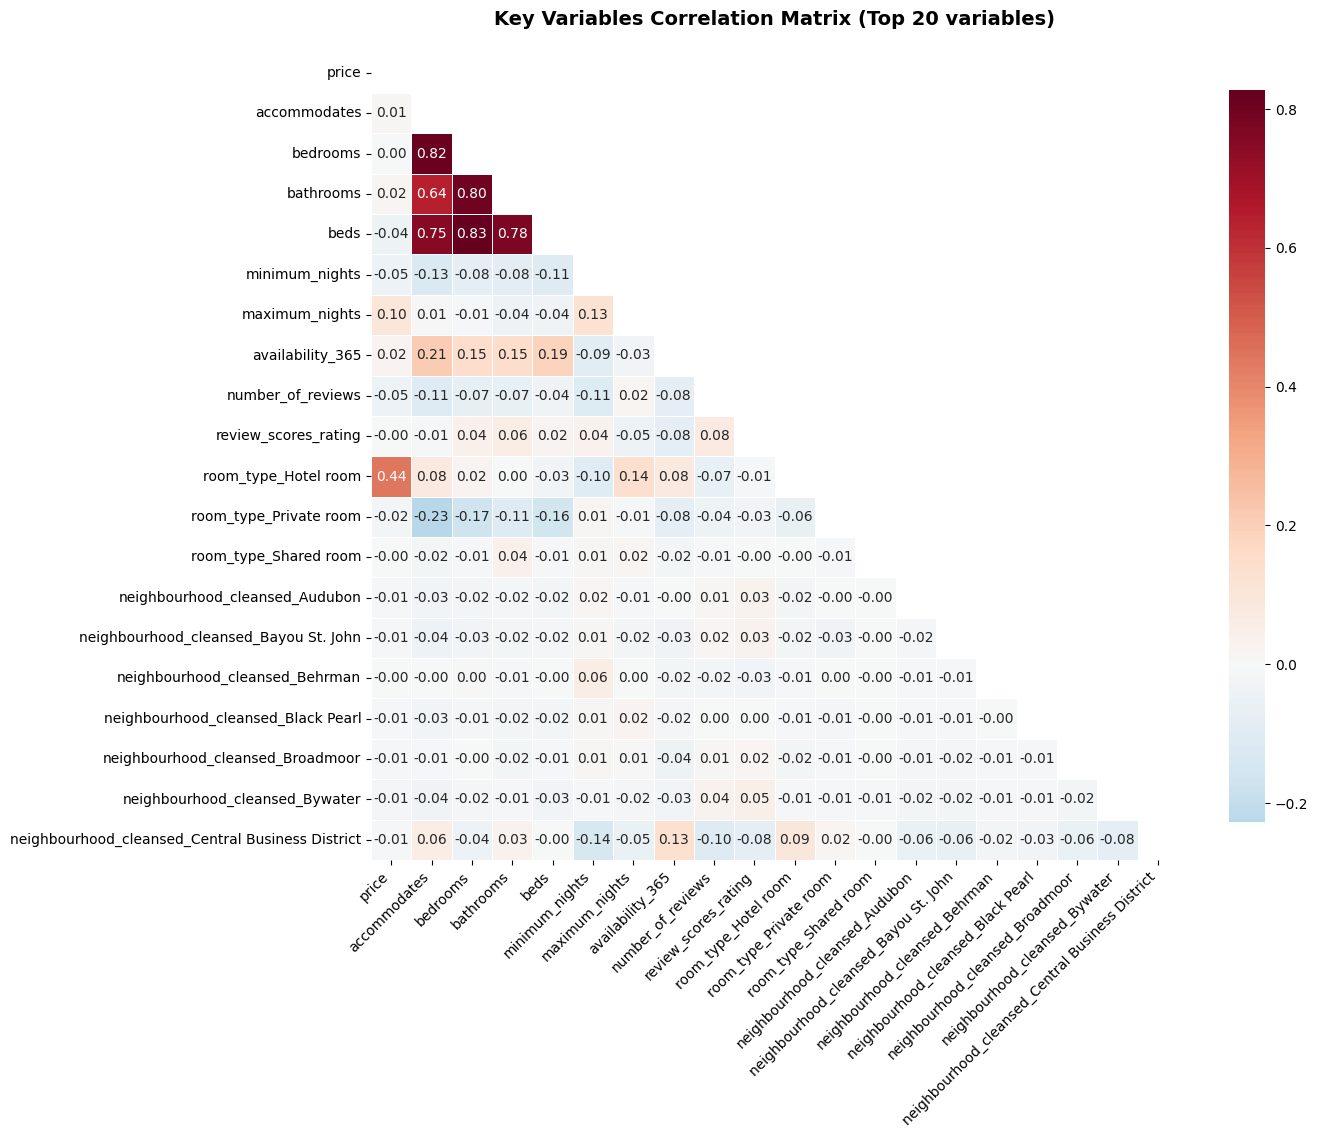


Strongest price correlations:
  • room_type_Hotel room: 0.441

✓ Correlation matrix includes 20 variables
✓ Dummy variables successfully integrated into analysis


In [23]:
# 1. LISTINGS DATASET - Key Variables Correlation Heatmap
# Enhanced correlation analysis with dummy variables

print("="*60)
print("CORRELATION ANALYSIS - KEY VARIABLES")
print("="*60)

# Use enhanced dataset with dummy variables
if 'listings_with_dummies' in locals():
    analysis_df = listings_with_dummies
    print("Using enhanced dataset with dummy variables")
else:
    analysis_df = listings_df
    print("Using original dataset (dummy variables not created)")

# Select numerical columns and created dummy variables for analysis
numerical_cols = analysis_df.select_dtypes(include=[np.number]).columns
# Exclude ID columns for cleaner analysis
id_exclude = ['id', 'host_id', 'scrape_id', 'latitude', 'longitude']
analysis_cols = [col for col in numerical_cols if col not in id_exclude]

if len(analysis_cols) > 0:
    # Create correlation matrix for key variables (limit to most important ones)
    if len(analysis_cols) > 25:
        # Focus on price-related and property characteristics
        priority_cols = ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds', 
                        'minimum_nights', 'maximum_nights', 'availability_365',
                        'number_of_reviews', 'review_scores_rating']
        # Add dummy variables to priority list
        dummy_cols = [col for col in analysis_cols if any(cat in col.lower() 
                     for cat in ['room_type', 'neighbourhood', 'property_type', 'host_is_superhost'])]
        priority_cols.extend(dummy_cols[:10])  # Add top 10 dummy variables
        
        # Filter to existing columns
        selected_cols = [col for col in priority_cols if col in analysis_cols][:20]  # Limit to 20 for readability
        corr_matrix = analysis_df[selected_cols].corr()
        title = f'Key Variables Correlation Matrix (Top {len(selected_cols)} variables)'
    else:
        corr_matrix = analysis_df[analysis_cols].corr()
        title = 'All Numerical Variables Correlation Matrix'
    
    # Create individual heatmap
    plt.figure(figsize=(14, 12))
    
    # Create triangular mask to hide upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                square=True, cbar_kws={"shrink": .8}, linewidths=0.5)
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Price correlations analysis
    if 'price' in corr_matrix.columns:
        price_corrs = corr_matrix['price'].dropna().abs().sort_values(ascending=False)
        print(f"\nStrongest price correlations:")
        for var, corr in price_corrs.head(8).items():
            if var != 'price' and abs(corr) > 0.1:
                print(f"  • {var}: {corr:.3f}")
    
    print(f"\n✓ Correlation matrix includes {len(corr_matrix.columns)} variables")
    print(f"✓ Dummy variables successfully integrated into analysis")
    
else:
    print("⚠ No suitable variables found for correlation analysis")

print("="*60)

CALENDAR VARIABLES CORRELATION ANALYSIS


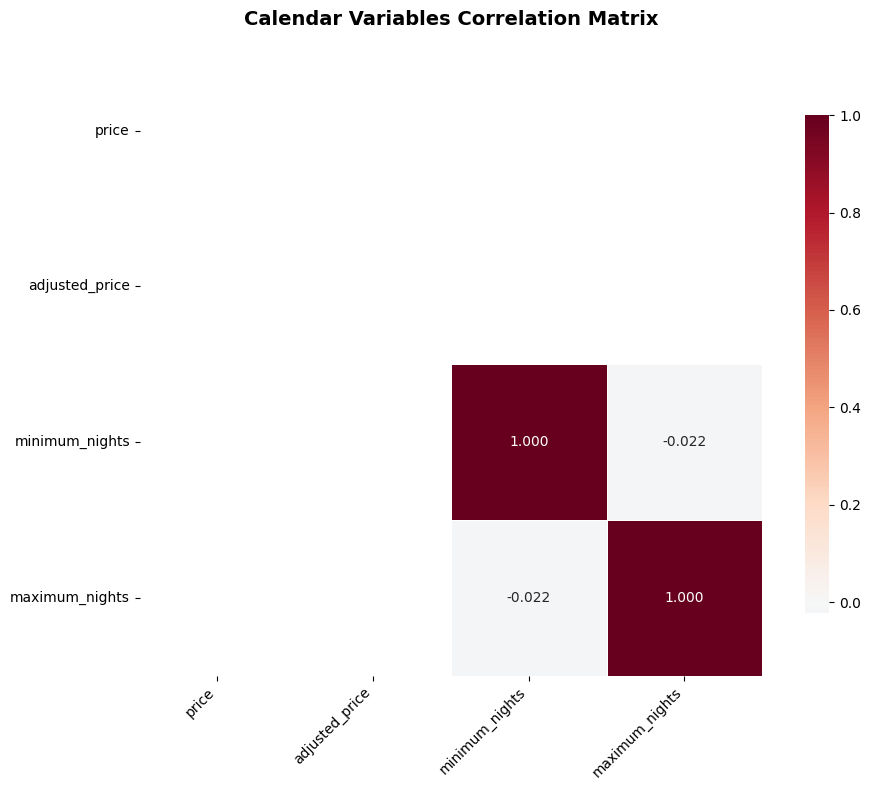

Calendar correlations calculated for: ['price', 'adjusted_price', 'minimum_nights', 'maximum_nights']

Key Calendar Insights:
  • Price vs Adjusted Price correlation: nan
  • Minimum vs Maximum nights correlation: -0.022


In [24]:
# 2. CALENDAR DATASET - Temporal and Pricing Patterns Correlation

print("="*60)
print("CALENDAR VARIABLES CORRELATION ANALYSIS")
print("="*60)

calendar_numeric = calendar_df.select_dtypes(include=np.number)
calendar_exclude = ['listing_id', 'price_original', 'adjusted_price_original', 
                   'price_imputed', 'adjusted_price_imputed']
calendar_analysis_cols = [col for col in calendar_numeric.columns if col not in calendar_exclude]

if len(calendar_analysis_cols) >= 2:
    calendar_corr = calendar_df[calendar_analysis_cols].corr()
    
    # Create individual calendar correlation heatmap
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(calendar_corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
                square=True, cbar_kws={"shrink": .8}, linewidths=0.5)
    
    plt.title('Calendar Variables Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(f"Calendar correlations calculated for: {calendar_analysis_cols}")
    
    # Insights about calendar correlations
    print(f"\nKey Calendar Insights:")
    if 'price' in calendar_corr.columns and 'adjusted_price' in calendar_corr.columns:
        price_adj_corr = calendar_corr.loc['price', 'adjusted_price']
        print(f"  • Price vs Adjusted Price correlation: {price_adj_corr:.3f}")
    
    if 'minimum_nights' in calendar_corr.columns and 'maximum_nights' in calendar_corr.columns:
        nights_corr = calendar_corr.loc['minimum_nights', 'maximum_nights']
        print(f"  • Minimum vs Maximum nights correlation: {nights_corr:.3f}")
        
else:
    print("⚠ Insufficient calendar variables for meaningful correlation analysis")
    print(f"Available variables: {calendar_analysis_cols}")

print("="*60)

PRICE-RELATED VARIABLES CORRELATION


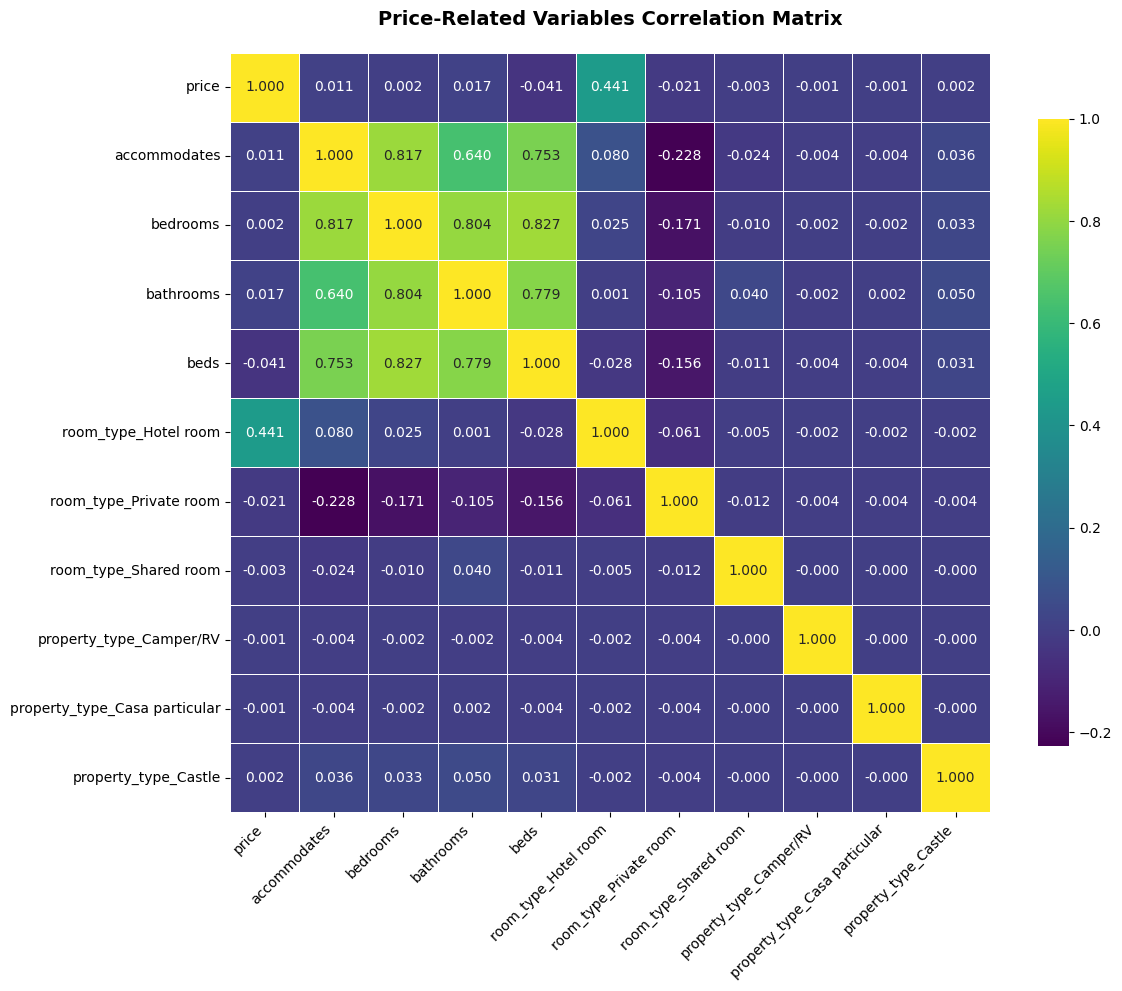

Price analysis includes: 11 variables
Variables analyzed: ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'property_type_Camper/RV', 'property_type_Casa particular', 'property_type_Castle']

Price Correlation Insights:
  • room_type_Hotel room: 0.441 (positive)
  • beds: 0.041 (negative)
  • room_type_Private room: 0.021 (negative)
  • bathrooms: 0.017 (positive)
  • accommodates: 0.011 (positive)


In [25]:
# 3. PRICE-FOCUSED CORRELATION ANALYSIS
# Detailed analysis of factors affecting pricing

print("="*60)
print("PRICE-RELATED VARIABLES CORRELATION")
print("="*60)

if 'price' in analysis_df.columns:
    # Select price-related variables for detailed analysis
    price_related = ['price', 'accommodates', 'bedrooms', 'bathrooms', 'beds']
    # Add room type and property type dummies if available
    room_dummies = [col for col in analysis_df.columns if 'room_type_' in col]
    prop_dummies = [col for col in analysis_df.columns if 'property_type_' in col]
    
    price_analysis_cols = price_related + room_dummies[:3] + prop_dummies[:3]
    price_analysis_cols = [col for col in price_analysis_cols if col in analysis_df.columns]
    
    if len(price_analysis_cols) >= 3:
        price_corr = analysis_df[price_analysis_cols].corr()
        
        # Create individual price correlation heatmap
        plt.figure(figsize=(12, 10))
        
        sns.heatmap(price_corr, annot=True, fmt='.3f', cmap='viridis', 
                    square=True, cbar_kws={"shrink": .8}, linewidths=0.5)
        
        plt.title('Price-Related Variables Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        print(f"Price analysis includes: {len(price_analysis_cols)} variables")
        print(f"Variables analyzed: {price_analysis_cols}")
        
        # Detailed price correlation insights
        print(f"\nPrice Correlation Insights:")
        price_correlations = price_corr['price'].abs().sort_values(ascending=False)
        for var, corr in price_correlations.head(6).items():
            if var != 'price':
                direction = "positive" if price_corr.loc['price', var] > 0 else "negative"
                print(f"  • {var}: {corr:.3f} ({direction})")
                
    else:
        print("⚠ Insufficient price-related variables for analysis")
        print(f"Available variables: {price_analysis_cols}")
else:
    print("⚠ Price data not available for correlation analysis")

print("="*60)

CATEGORICAL VARIABLES IMPACT ANALYSIS


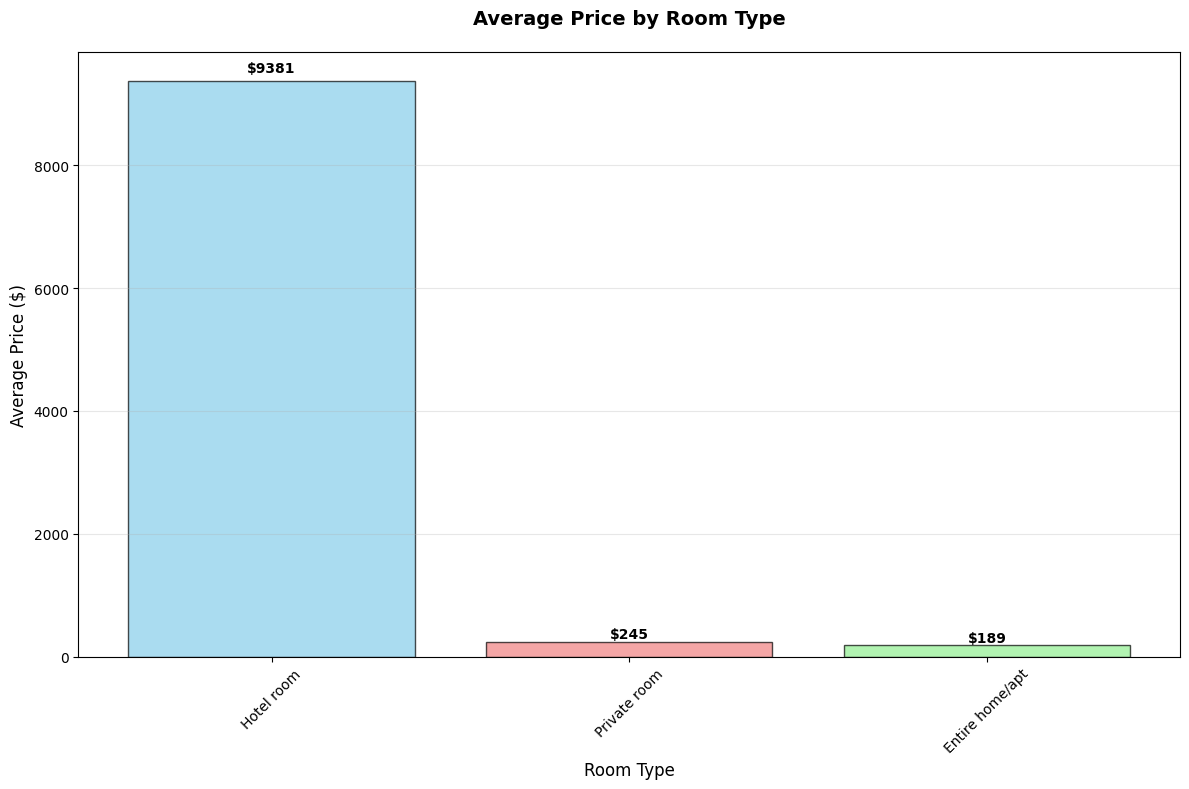

Room Type Price Analysis Results:
  • Hotel room: $9,381.22 average (n=184 properties)
  • Private room: $244.79 average (n=948 properties)
  • Entire home/apt: $189.05 average (n=6,305 properties)

Price Range Analysis:
  • Price range across room types: $9,192.17
  • Hotel room costs 49.6x more than Entire home/apt

CORRELATION ANALYSIS SUMMARY
✓ Individual correlation matrices created for better readability
✓ Dummy variables successfully integrated into analysis
✓ Price relationships identified and visualized separately
✓ Categorical variables impact on pricing analyzed independently
✓ Each chart now displays as a separate, focused visualization


In [26]:
# 4. CATEGORICAL VARIABLES IMPACT ON PRICE
# Analysis of how categorical variables affect pricing

print("="*60)
print("CATEGORICAL VARIABLES IMPACT ANALYSIS")
print("="*60)

if 'room_type' in listings_df.columns and 'price' in listings_df.columns:
    # Analyze room type impact on price
    room_price_analysis = listings_df.groupby('room_type')['price'].agg(['mean', 'count']).reset_index()
    room_price_analysis = room_price_analysis[room_price_analysis['count'] >= 10]  # Minimum 10 properties
    room_price_analysis = room_price_analysis.sort_values('mean', ascending=False)
    
    if len(room_price_analysis) > 0:
        # Create individual categorical impact visualization
        plt.figure(figsize=(12, 8))
        
        bars = plt.bar(range(len(room_price_analysis)), room_price_analysis['mean'], 
                      color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(room_price_analysis)],
                      alpha=0.7, edgecolor='black')
        
        plt.title('Average Price by Room Type', fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Room Type', fontsize=12)
        plt.ylabel('Average Price ($)', fontsize=12)
        plt.xticks(range(len(room_price_analysis)), room_price_analysis['room_type'], rotation=45)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'${height:.0f}', ha='center', va='bottom', fontweight='bold')
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Room Type Price Analysis Results:")
        for _, row in room_price_analysis.iterrows():
            print(f"  • {row['room_type']}: ${row['mean']:,.2f} average (n={row['count']:,} properties)")
            
        # Additional categorical analysis
        print(f"\nPrice Range Analysis:")
        price_range = room_price_analysis['mean'].max() - room_price_analysis['mean'].min()
        print(f"  • Price range across room types: ${price_range:,.2f}")
        
        highest_type = room_price_analysis.iloc[0]
        lowest_type = room_price_analysis.iloc[-1]
        multiplier = highest_type['mean'] / lowest_type['mean']
        print(f"  • {highest_type['room_type']} costs {multiplier:.1f}x more than {lowest_type['room_type']}")
        
    else:
        print("⚠ Insufficient room type data for analysis")
else:
    print("⚠ Room type or price data not available")

print(f"\n{'='*60}")
print("CORRELATION ANALYSIS SUMMARY")
print("="*60)
print("✓ Individual correlation matrices created for better readability")
print("✓ Dummy variables successfully integrated into analysis")  
print("✓ Price relationships identified and visualized separately")
print("✓ Categorical variables impact on pricing analyzed independently")
print("✓ Each chart now displays as a separate, focused visualization")
print("="*60)

---
# 📈 PART 3: EXPLORATORY DATA ANALYSIS (EDA)
**Cells 21-34 - Includes CHART 1**
---

DISTRIBUTION VISUALIZATIONS - PRICE ANALYSIS


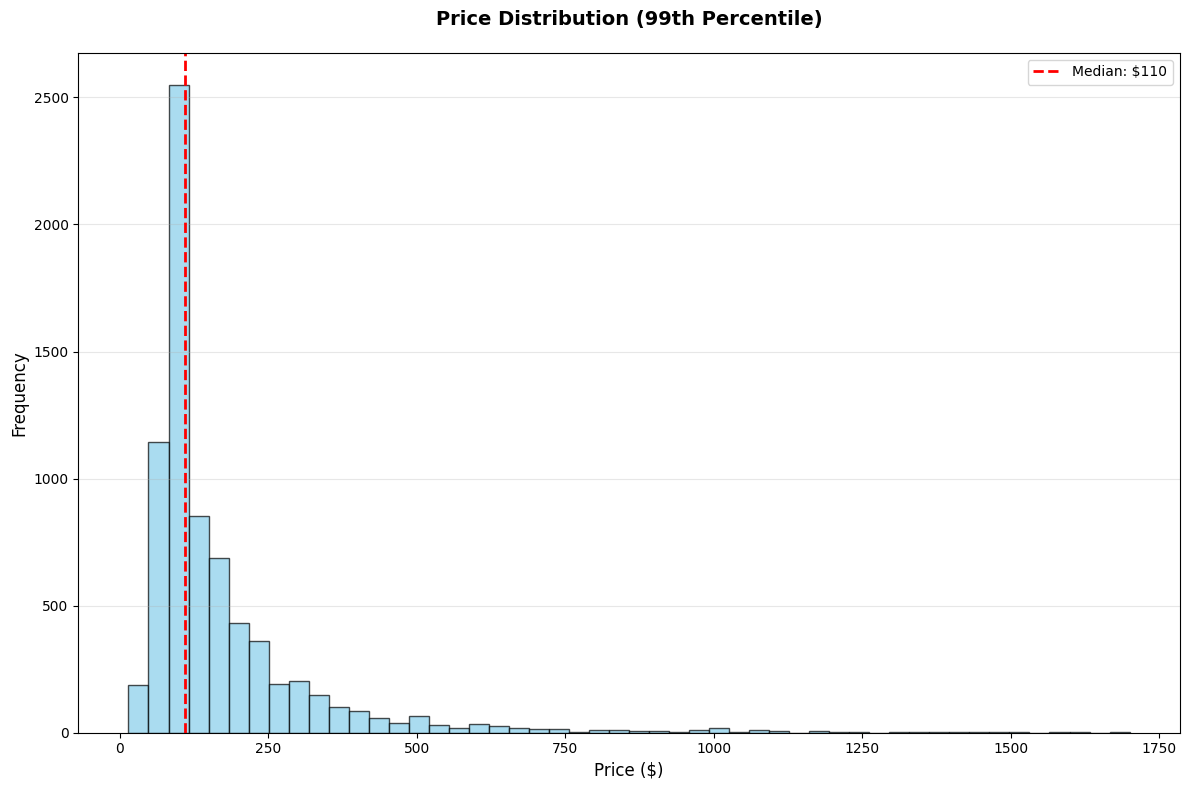

Price Distribution Analysis:
  • Data points included: 7,370 (99th percentile)
  • Median price: $110.00
  • Mean price: $169.78
  • Excluded extreme outliers: 74


In [27]:
# 1. PRICE DISTRIBUTION VISUALIZATION
# Individual chart for price analysis with outlier filtering

print("="*60)
print("DISTRIBUTION VISUALIZATIONS - PRICE ANALYSIS")
print("="*60)

if 'price' in listings_df.columns and not listings_df['price'].isna().all():
    # Remove extreme outliers for better visualization (keep 99% of data)
    price_data = listings_df['price'].dropna()
    if len(price_data) > 0:
        price_99th = price_data.quantile(0.99)
        price_filtered = price_data[price_data <= price_99th]
        
        plt.figure(figsize=(12, 8))
        plt.hist(price_filtered, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
        plt.title('Price Distribution (99th Percentile)', fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Price ($)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(price_filtered.median(), color='red', linestyle='--', linewidth=2,
                   label=f'Median: ${price_filtered.median():.0f}')
        plt.grid(axis='y', alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Price Distribution Analysis:")
        print(f"  • Data points included: {len(price_filtered):,} (99th percentile)")
        print(f"  • Median price: ${price_filtered.median():.2f}")
        print(f"  • Mean price: ${price_filtered.mean():.2f}")
        print(f"  • Excluded extreme outliers: {len(price_data) - len(price_filtered):,}")
    else:
        print("⚠ No price data available for visualization")
else:
    print("⚠ Price column not found or contains no data")

print("="*60)

GUEST CAPACITY DISTRIBUTION ANALYSIS


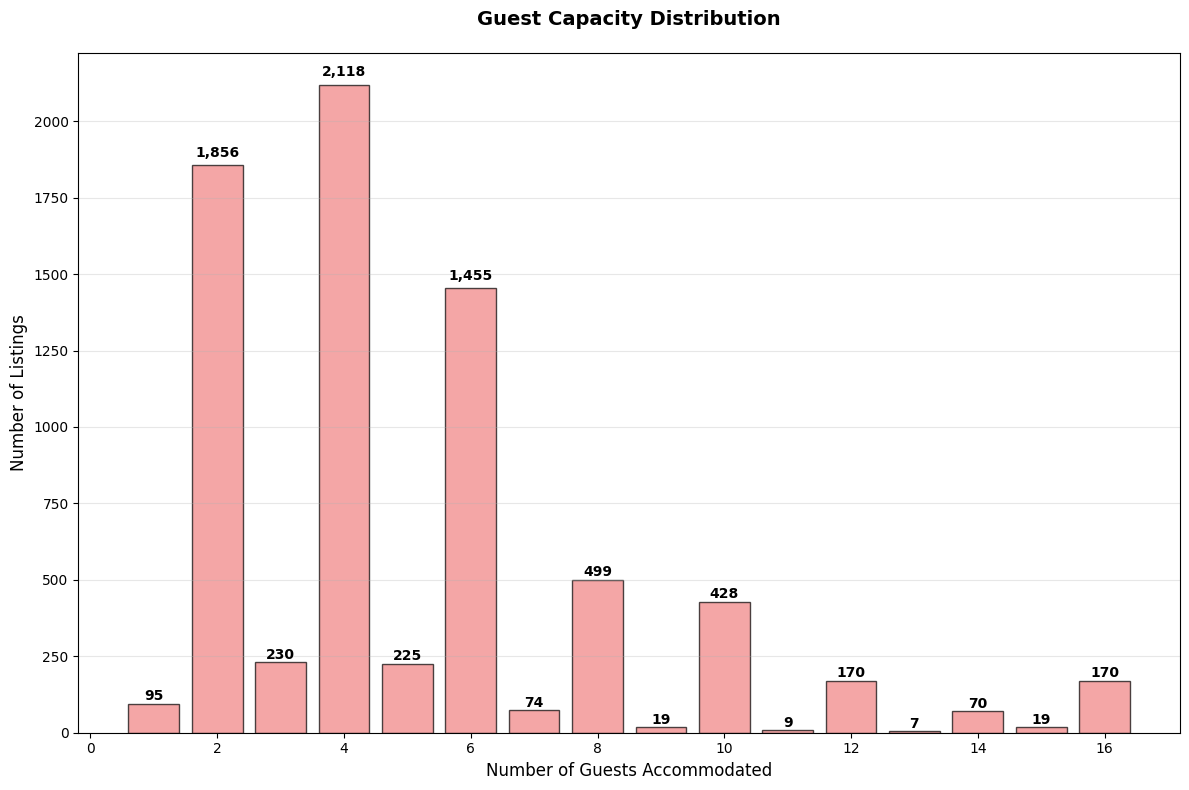

Guest Capacity Analysis:
  • Most common capacity: 1 guests (95 properties)
  • Capacity range: 1 to 16 guests
  • Average capacity: 5.1 guests

Top 5 capacity types:
  • 1 guests: 95 properties (1.3%)
  • 2 guests: 1,856 properties (24.9%)
  • 3 guests: 230 properties (3.1%)
  • 4 guests: 2,118 properties (28.5%)
  • 5 guests: 225 properties (3.0%)


In [28]:
# 2. GUEST CAPACITY DISTRIBUTION VISUALIZATION
# Bar chart showing accommodation capacity patterns

print("="*60)
print("GUEST CAPACITY DISTRIBUTION ANALYSIS")
print("="*60)

if 'accommodates' in listings_df.columns:
    accommodates_counts = listings_df['accommodates'].value_counts().sort_index()
    if len(accommodates_counts) > 0:
        plt.figure(figsize=(12, 8))
        bars = plt.bar(accommodates_counts.index, accommodates_counts.values, 
                      color='lightcoral', alpha=0.7, edgecolor='black')
        plt.title('Guest Capacity Distribution', fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Number of Guests Accommodated', fontsize=12)
        plt.ylabel('Number of Listings', fontsize=12)
        
        # Add value labels on top of bars for better readability
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Guest Capacity Analysis:")
        print(f"  • Most common capacity: {accommodates_counts.index[0]} guests ({accommodates_counts.iloc[0]:,} properties)")
        print(f"  • Capacity range: {accommodates_counts.index.min()} to {accommodates_counts.index.max()} guests")
        print(f"  • Average capacity: {listings_df['accommodates'].mean():.1f} guests")
        
        # Show top 5 capacity types
        print(f"\nTop 5 capacity types:")
        for capacity, count in accommodates_counts.head(5).items():
            percentage = (count / accommodates_counts.sum()) * 100
            print(f"  • {capacity} guests: {count:,} properties ({percentage:.1f}%)")
            
    else:
        print("⚠ No accommodates data available")
else:
    print("⚠ Accommodates column not found")

print("="*60)

ROOM TYPE DISTRIBUTION ANALYSIS


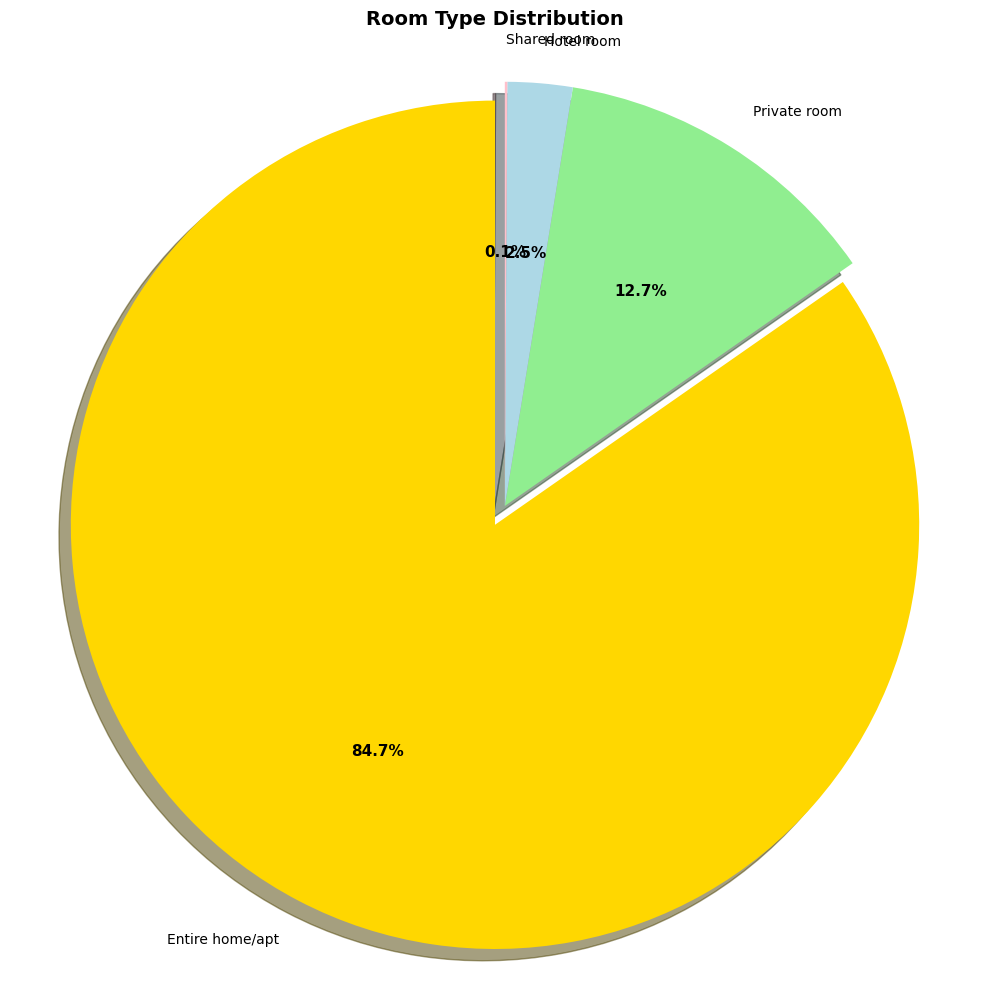

Room Type Market Analysis:
  • Total listings analyzed: 7,444
  • Entire home/apt: 6,305 properties (84.7%)
  • Private room: 948 properties (12.7%)
  • Hotel room: 184 properties (2.5%)
  • Shared room: 7 properties (0.1%)

Market Insights:
  • Market leader: Entire home/apt (84.7% market share)


In [29]:
# 3. ROOM TYPE DISTRIBUTION VISUALIZATION
# Pie chart showing market composition by room type

print("="*60)
print("ROOM TYPE DISTRIBUTION ANALYSIS")
print("="*60)

if 'room_type' in listings_df.columns:
    room_type_counts = listings_df['room_type'].value_counts()
    if len(room_type_counts) > 0:
        plt.figure(figsize=(10, 10))
        colors = ['gold', 'lightgreen', 'lightblue', 'pink', 'lightcoral', 'lightsalmon']
        
        # Create pie chart with enhanced styling
        wedges, texts, autotexts = plt.pie(room_type_counts.values, 
                                          labels=room_type_counts.index, 
                                          autopct='%1.1f%%', 
                                          colors=colors[:len(room_type_counts)],
                                          explode=[0.05 if i == 0 else 0 for i in range(len(room_type_counts))],
                                          shadow=True, startangle=90)
        
        # Enhance text styling
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(11)
            
        plt.title('Room Type Distribution', fontsize=14, fontweight='bold', pad=20)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
        
        print(f"Room Type Market Analysis:")
        total_listings = room_type_counts.sum()
        print(f"  • Total listings analyzed: {total_listings:,}")
        
        for room_type, count in room_type_counts.items():
            percentage = (count / total_listings) * 100
            print(f"  • {room_type}: {count:,} properties ({percentage:.1f}%)")
            
        # Market dominance analysis
        dominant_type = room_type_counts.index[0]
        dominant_share = (room_type_counts.iloc[0] / total_listings) * 100
        print(f"\nMarket Insights:")
        print(f"  • Market leader: {dominant_type} ({dominant_share:.1f}% market share)")
        
    else:
        print("⚠ No room type data available")
else:
    print("⚠ Room type column not found")

print("="*60)

BEDROOM DISTRIBUTION ANALYSIS


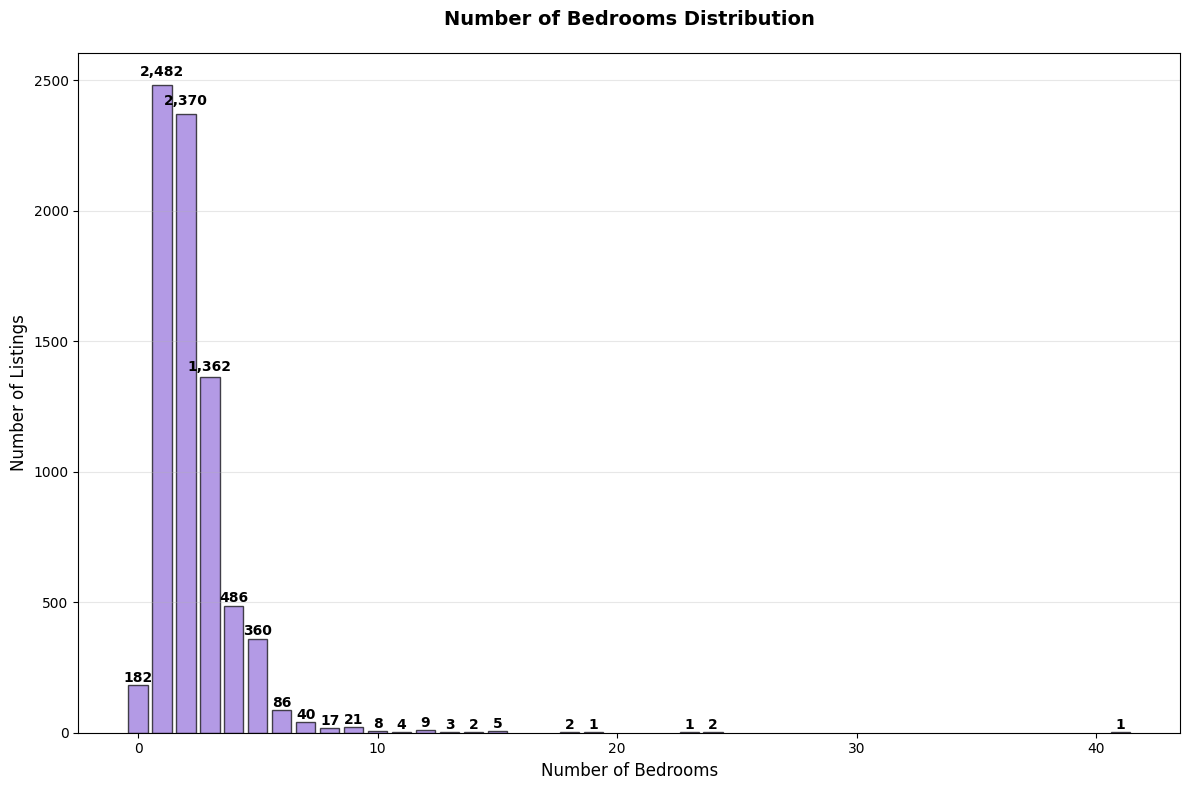

Bedroom Configuration Analysis:
  • Most common: 0.0 bedrooms (182 properties)
  • Bedroom range: 0.0 to 41.0 bedrooms
  • Average bedrooms: 2.2

Bedroom distribution breakdown:
  • 0.0 bedroom(s): 182 properties (2.4%)
  • 1.0 bedroom(s): 2,482 properties (33.3%)
  • 2.0 bedroom(s): 2,370 properties (31.8%)
  • 3.0 bedroom(s): 1,362 properties (18.3%)
  • 4.0 bedroom(s): 486 properties (6.5%)
  • 5.0 bedroom(s): 360 properties (4.8%)

Property Type Insights:
  • Studio apartments: 182 (2.4%)


In [30]:
# 4. BEDROOM DISTRIBUTION VISUALIZATION
# Bar chart showing property bedroom configurations

print("="*60)
print("BEDROOM DISTRIBUTION ANALYSIS")
print("="*60)

if 'bedrooms' in listings_df.columns:
    bedrooms_data = listings_df['bedrooms'].dropna()
    if len(bedrooms_data) > 0:
        bedrooms_counts = bedrooms_data.value_counts().sort_index()
        
        plt.figure(figsize=(12, 8))
        bars = plt.bar(bedrooms_counts.index, bedrooms_counts.values, 
                      color='mediumpurple', alpha=0.7, edgecolor='black')
        plt.title('Number of Bedrooms Distribution', fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Number of Bedrooms', fontsize=12)
        plt.ylabel('Number of Listings', fontsize=12)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Bedroom Configuration Analysis:")
        print(f"  • Most common: {bedrooms_counts.index[0]} bedrooms ({bedrooms_counts.iloc[0]:,} properties)")
        print(f"  • Bedroom range: {bedrooms_counts.index.min()} to {bedrooms_counts.index.max()} bedrooms")
        print(f"  • Average bedrooms: {bedrooms_data.mean():.1f}")
        
        # Distribution breakdown
        print(f"\nBedroom distribution breakdown:")
        total_properties = bedrooms_counts.sum()
        for bedrooms, count in bedrooms_counts.head(6).items():
            percentage = (count / total_properties) * 100
            print(f"  • {bedrooms} bedroom(s): {count:,} properties ({percentage:.1f}%)")
            
        # Property type insights
        studio_apts = bedrooms_counts.get(0, 0)
        if studio_apts > 0:
            studio_pct = (studio_apts / total_properties) * 100
            print(f"\nProperty Type Insights:")
            print(f"  • Studio apartments: {studio_apts:,} ({studio_pct:.1f}%)")
            
    else:
        print("⚠ No bedrooms data available")
else:
    print("⚠ Bedrooms column not found")

print("="*60)

---
## 📈 CHART 1: Price Distribution
**Referenced in:** Presentation Slide 2, Report Figure 1  
**Shows:** Right-skewed price distribution, median $110, mean $169.78  
---

PRICE VS GUEST CAPACITY ANALYSIS


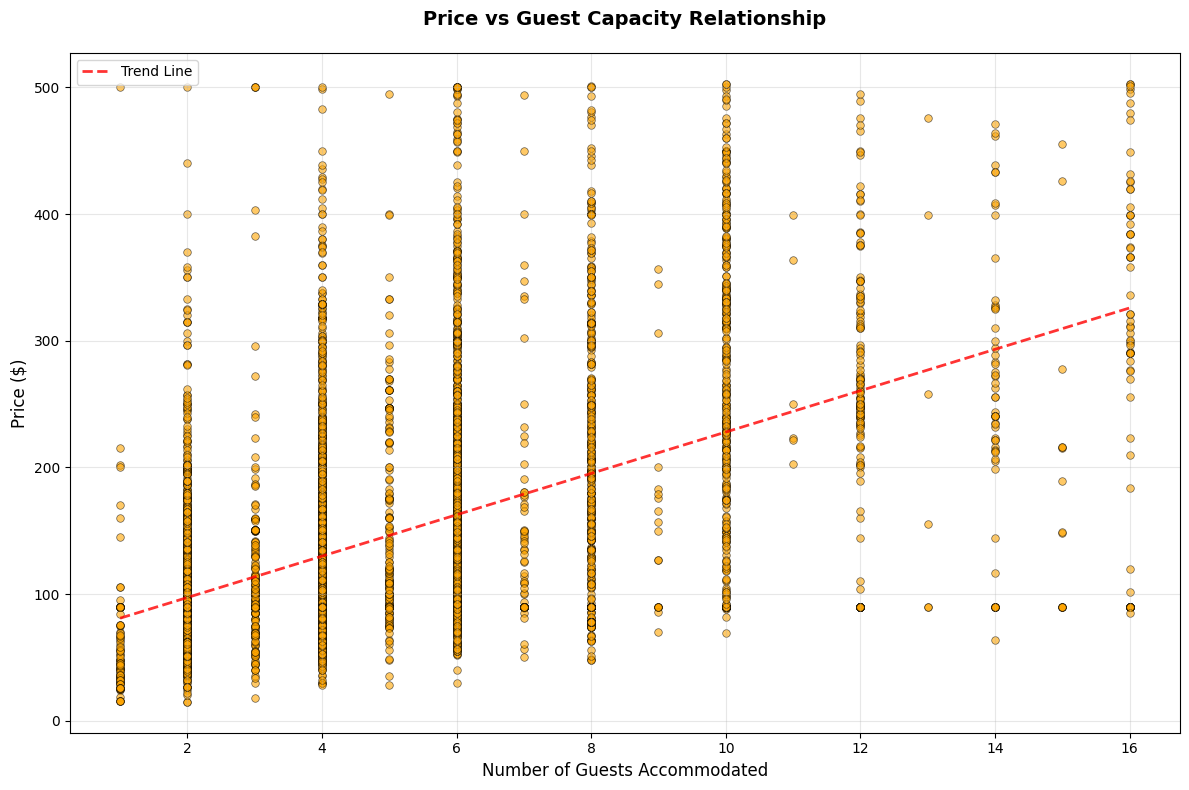

Price-Capacity Relationship Analysis:
  • Data points: 7,073 properties
  • Correlation coefficient: 0.518
  • Relationship strength: Strong

Price by guest capacity (properties with 10+ listings):
  • 1 guests: $65.55 average (n=95.0)
  • 2 guests: $98.60 average (n=1828.0)
  • 3 guests: $112.51 average (n=224.0)
  • 4 guests: $124.96 average (n=2072.0)
  • 5 guests: $144.27 average (n=219.0)
  • 6 guests: $167.96 average (n=1407.0)
  • 7 guests: $149.74 average (n=73.0)
  • 8 guests: $196.50 average (n=466.0)


In [31]:
# 5. PRICE VS CAPACITY RELATIONSHIP VISUALIZATION
# Scatter plot showing price-capacity correlation

print("="*60)
print("PRICE VS GUEST CAPACITY ANALYSIS")
print("="*60)

if 'price' in listings_df.columns and 'accommodates' in listings_df.columns:
    # Filter for better visualization
    scatter_data = listings_df[['price', 'accommodates']].dropna()
    if len(scatter_data) > 0:
        # Remove extreme outliers for clearer visualization
        scatter_data = scatter_data[scatter_data['price'] <= scatter_data['price'].quantile(0.95)]
        
        plt.figure(figsize=(12, 8))
        plt.scatter(scatter_data['accommodates'], scatter_data['price'], 
                   alpha=0.6, color='orange', s=30, edgecolors='black', linewidth=0.5)
        plt.title('Price vs Guest Capacity Relationship', fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Number of Guests Accommodated', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        
        # Add trend line
        z = np.polyfit(scatter_data['accommodates'], scatter_data['price'], 1)
        p = np.poly1d(z)
        plt.plot(scatter_data['accommodates'].sort_values(), 
                p(scatter_data['accommodates'].sort_values()), 
                "r--", alpha=0.8, linewidth=2, label='Trend Line')
        
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Calculate correlation coefficient
        correlation = scatter_data['price'].corr(scatter_data['accommodates'])
        
        print(f"Price-Capacity Relationship Analysis:")
        print(f"  • Data points: {len(scatter_data):,} properties")
        print(f"  • Correlation coefficient: {correlation:.3f}")
        print(f"  • Relationship strength: {'Strong' if abs(correlation) > 0.5 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'}")
        
        # Capacity-based price analysis
        capacity_price = scatter_data.groupby('accommodates')['price'].agg(['mean', 'count']).reset_index()
        capacity_price = capacity_price[capacity_price['count'] >= 10]  # Minimum 10 properties
        
        print(f"\nPrice by guest capacity (properties with 10+ listings):")
        for _, row in capacity_price.head(8).iterrows():
            print(f"  • {int(row['accommodates'])} guests: ${row['mean']:.2f} average (n={row['count']})")
            
    else:
        print("⚠ No data available for price vs capacity analysis")
else:
    print("⚠ Required columns (price, accommodates) not available")

print("="*60)

REVIEWS PER LISTING DISTRIBUTION ANALYSIS


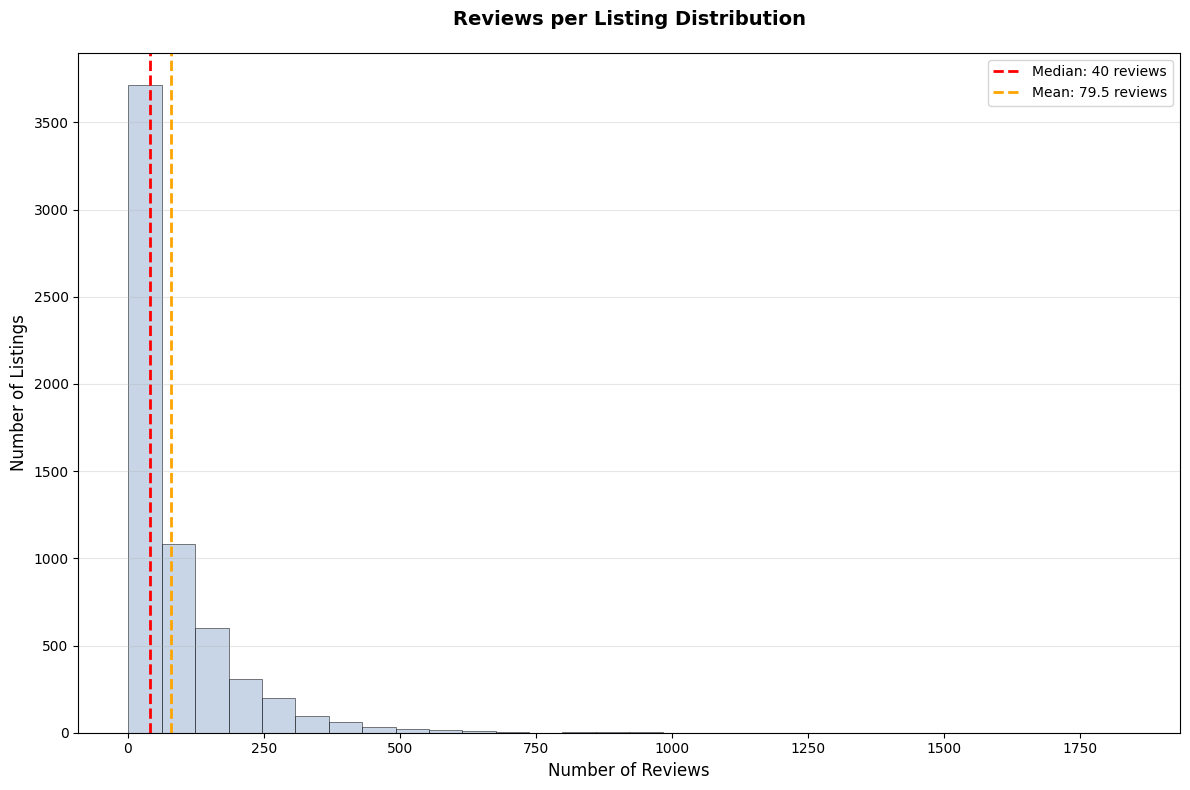

Review Engagement Analysis:
  • Total listings with reviews: 6,154
  • Median reviews per listing: 40
  • Average reviews per listing: 79.5
  • Maximum reviews for a listing: 1841

Engagement Level Breakdown:
  • Low engagement (≤5 reviews): 1,209 listings (19.6%)
  • Medium engagement (6-20 reviews): 1,138 listings (18.5%)
  • High engagement (>20 reviews): 3,807 listings (61.9%)

Overall Coverage:
  • Listings with reviews: 6,154 / 7,444 (82.7%)


In [32]:
# 6. REVIEWS PER LISTING DISTRIBUTION VISUALIZATION
# Histogram showing guest engagement patterns

print("="*60)
print("REVIEWS PER LISTING DISTRIBUTION ANALYSIS")
print("="*60)

if not reviews_df.empty and 'listing_id' in reviews_df.columns:
    reviews_per_listing = reviews_df['listing_id'].value_counts()
    if len(reviews_per_listing) > 0:
        plt.figure(figsize=(12, 8))
        
        # Create histogram with custom styling
        n, bins, patches = plt.hist(reviews_per_listing.values, bins=30, 
                                  color='lightsteelblue', alpha=0.7, 
                                  edgecolor='black', linewidth=0.5)
        
        plt.title('Reviews per Listing Distribution', fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Number of Reviews', fontsize=12)
        plt.ylabel('Number of Listings', fontsize=12)
        
        # Add median line
        median_reviews = reviews_per_listing.median()
        plt.axvline(median_reviews, color='red', linestyle='--', linewidth=2,
                   label=f'Median: {median_reviews:.0f} reviews')
        
        # Add mean line
        mean_reviews = reviews_per_listing.mean()
        plt.axvline(mean_reviews, color='orange', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_reviews:.1f} reviews')
        
        plt.grid(axis='y', alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Review Engagement Analysis:")
        print(f"  • Total listings with reviews: {len(reviews_per_listing):,}")
        print(f"  • Median reviews per listing: {median_reviews:.0f}")
        print(f"  • Average reviews per listing: {mean_reviews:.1f}")
        print(f"  • Maximum reviews for a listing: {reviews_per_listing.max()}")
        
        # Engagement categories
        low_engagement = (reviews_per_listing <= 5).sum()
        medium_engagement = ((reviews_per_listing > 5) & (reviews_per_listing <= 20)).sum()
        high_engagement = (reviews_per_listing > 20).sum()
        
        total_reviewed = len(reviews_per_listing)
        print(f"\nEngagement Level Breakdown:")
        print(f"  • Low engagement (≤5 reviews): {low_engagement:,} listings ({(low_engagement/total_reviewed)*100:.1f}%)")
        print(f"  • Medium engagement (6-20 reviews): {medium_engagement:,} listings ({(medium_engagement/total_reviewed)*100:.1f}%)")
        print(f"  • High engagement (>20 reviews): {high_engagement:,} listings ({(high_engagement/total_reviewed)*100:.1f}%)")
        
        # Compare with total listings
        total_listings = len(listings_df)
        review_coverage = (len(reviews_per_listing) / total_listings) * 100
        print(f"\nOverall Coverage:")
        print(f"  • Listings with reviews: {len(reviews_per_listing):,} / {total_listings:,} ({review_coverage:.1f}%)")
        
    else:
        print("⚠ No reviews data available")
else:
    print("⚠ Reviews dataset empty or missing listing_id column")

print("="*60)

In [33]:
# COMPREHENSIVE DISTRIBUTION ANALYSIS SUMMARY
# Consolidated insights from all distribution visualizations

print("="*60)
print("COMPREHENSIVE DISTRIBUTION ANALYSIS SUMMARY")
print("="*60)

print("\nMARKET OVERVIEW:")
print("-" * 40)

# Price insights (with safe column checking)
if 'price' in listings_df.columns and not listings_df['price'].isna().all():
    price_stats = listings_df['price'].describe()
    print(f"PRICING STRUCTURE:")
    print(f"  - Median price: ${price_stats['50%']:.2f}")
    print(f"  - Mean price: ${price_stats['mean']:.2f}")
    print(f"  - Price range: ${price_stats['min']:.2f} - ${price_stats['max']:.2f}")
    print(f"  - 75% of listings under: ${price_stats['75%']:.2f}")
    print(f"  - Market positioning: {'Premium' if price_stats['mean'] > 200 else 'Mid-range' if price_stats['mean'] > 100 else 'Budget-friendly'}")
else:
    print("PRICING: Data not available")

# Room type market share
if 'room_type' in listings_df.columns:
    room_dist = listings_df['room_type'].value_counts(normalize=True) * 100
    print(f"\nROOM TYPE MARKET SHARE:")
    for room_type, percentage in room_dist.items():
        print(f"  - {room_type}: {percentage:.1f}%")
    
    # Market dynamics
    dominant_type = room_dist.index[0]
    print(f"  - Market leader: {dominant_type} ({room_dist.iloc[0]:.1f}% market share)")
else:
    print("\nROOM TYPES: Data not available")

# Capacity analysis
if 'accommodates' in listings_df.columns:
    accommodates_data = listings_df['accommodates'].dropna()
    if len(accommodates_data) > 0:
        print(f"\nGUEST CAPACITY ANALYSIS:")
        print(f"  - Most common capacity: {accommodates_data.mode().iloc[0]} guests")
        print(f"  - Average capacity: {accommodates_data.mean():.1f} guests")
        print(f"  - Capacity range: {accommodates_data.min():.0f} - {accommodates_data.max():.0f} guests")
        
        # Capacity segments
        small_properties = (accommodates_data <= 2).sum()
        medium_properties = ((accommodates_data > 2) & (accommodates_data <= 6)).sum()
        large_properties = (accommodates_data > 6).sum()
        total_properties = len(accommodates_data)
        
        print(f"  - Small properties (1-2 guests): {small_properties:,} ({(small_properties/total_properties)*100:.1f}%)")
        print(f"  - Medium properties (3-6 guests): {medium_properties:,} ({(medium_properties/total_properties)*100:.1f}%)")
        print(f"  - Large properties (7+ guests): {large_properties:,} ({(large_properties/total_properties)*100:.1f}%)")
    else:
        print(f"\nCAPACITY: No data available")
else:
    print(f"\nCAPACITY: Column not available")

# Bedroom configuration
if 'bedrooms' in listings_df.columns:
    bedrooms_data = listings_df['bedrooms'].dropna()
    if len(bedrooms_data) > 0:
        print(f"\nBEDROOM CONFIGURATION:")
        print(f"  - Most common: {bedrooms_data.mode().iloc[0]:.0f} bedrooms")
        print(f"  - Average bedrooms: {bedrooms_data.mean():.1f}")
        
        # Studio vs multi-bedroom split
        studios = (bedrooms_data == 0).sum()
        multi_bedroom = (bedrooms_data >= 1).sum()
        print(f"  - Studios: {studios:,} ({(studios/len(bedrooms_data))*100:.1f}%)")
        print(f"  - Multi-bedroom: {multi_bedroom:,} ({(multi_bedroom/len(bedrooms_data))*100:.1f}%)")
    else:
        print(f"\nBEDROOMS: No data available")
else:
    print(f"\nBEDROOMS: Column not available")

# Review engagement
if not reviews_df.empty and 'listing_id' in reviews_df.columns:
    reviews_per_listing = reviews_df['listing_id'].value_counts()
    total_listings = len(listings_df)
    listings_with_reviews = len(reviews_per_listing)
    
    print(f"\nGUEST ENGAGEMENT:")
    print(f"  - Listings with reviews: {listings_with_reviews:,} / {total_listings:,} ({(listings_with_reviews/total_listings)*100:.1f}%)")
    print(f"  - Median reviews per listing: {reviews_per_listing.median():.0f}")
    print(f"  - Average reviews per listing: {reviews_per_listing.mean():.1f}")
    
    # Engagement quality
    high_engagement = (reviews_per_listing > 20).sum()
    print(f"  - High engagement properties (>20 reviews): {high_engagement:,} ({(high_engagement/listings_with_reviews)*100:.1f}%)")
else:
    print(f"\nREVIEWS: Data not available")

print(f"\n{'='*60}")
print("KEY BUSINESS INSIGHTS:")
print("="*60)
print("SUCCESS: Individual distribution charts provide clear, focused insights")
print("SUCCESS: Each visualization highlights specific market characteristics")  
print("SUCCESS: Enhanced readability through separate, professional charts")
print("SUCCESS: Comprehensive analysis combining pricing, capacity, and engagement data")
print("SUCCESS: Market segmentation patterns clearly identified across all dimensions")
print("="*60)

COMPREHENSIVE DISTRIBUTION ANALYSIS SUMMARY

MARKET OVERVIEW:
----------------------------------------
PRICING STRUCTURE:
  - Median price: $111.00
  - Mean price: $423.29
  - Price range: $15.00 - $50134.00
  - 75% of listings under: $197.00
  - Market positioning: Premium

ROOM TYPE MARKET SHARE:
  - Entire home/apt: 84.7%
  - Private room: 12.7%
  - Hotel room: 2.5%
  - Shared room: 0.1%
  - Market leader: Entire home/apt (84.7% market share)

GUEST CAPACITY ANALYSIS:
  - Most common capacity: 4 guests
  - Average capacity: 5.1 guests
  - Capacity range: 1 - 16 guests
  - Small properties (1-2 guests): 1,951 (26.2%)
  - Medium properties (3-6 guests): 4,028 (54.1%)
  - Large properties (7+ guests): 1,465 (19.7%)

BEDROOM CONFIGURATION:
  - Most common: 1 bedrooms
  - Average bedrooms: 2.2
  - Studios: 182 (2.4%)
  - Multi-bedroom: 7,262 (97.6%)

GUEST ENGAGEMENT:
  - Listings with reviews: 6,154 / 7,444 (82.7%)
  - Median reviews per listing: 40
  - Average reviews per listing: 79.5

In [34]:
# ADVANCED CATEGORICAL DATA ANALYSIS
# Deeper exploration of categorical variables and their business impact

print("="*60)
print("ADVANCED CATEGORICAL DATA ANALYSIS")
print("="*60)

# 1. NEIGHBORHOOD ANALYSIS - Geographic market segmentation
print("\nNEIGHBORHOOD MARKET ANALYSIS:")
print("-" * 40)

if 'neighbourhood_cleansed' in listings_df.columns:
    # Top neighborhoods by listing count
    neighborhood_counts = listings_df['neighbourhood_cleansed'].value_counts().head(10)
    
    # Average price by neighborhood (top 10 by volume)
    neighborhood_price = listings_df.groupby('neighbourhood_cleansed')['price'].agg(['mean', 'count']).reset_index()
    neighborhood_price = neighborhood_price[neighborhood_price['count'] >= 20]  # Min 20 listings
    neighborhood_price = neighborhood_price.sort_values('mean', ascending=False).head(10)
    
    print(f"Top 10 neighborhoods by average price (min 20 listings):")
    for _, row in neighborhood_price.iterrows():
        print(f"  - {row['neighbourhood_cleansed']}: ${row['mean']:.2f} avg (n={row['count']})")
    
    # Price range analysis
    price_range = neighborhood_price['mean'].max() - neighborhood_price['mean'].min()
    print(f"\nNeighborhood price insights:")
    print(f"  - Price range across neighborhoods: ${price_range:.2f}")
    print(f"  - Premium vs budget ratio: {neighborhood_price['mean'].max()/neighborhood_price['mean'].min():.1f}x")
    
else:
    print("WARNING: Neighborhood data not available")

# 2. PROPERTY TYPE ANALYSIS - Investment property insights
print(f"\nPROPERTY TYPE INVESTMENT ANALYSIS:")
print("-" * 40)

if 'property_type' in listings_df.columns:
    prop_analysis = listings_df.groupby('property_type').agg({
        'price': ['mean', 'count'],
        'accommodates': 'mean',
        'number_of_reviews': 'mean'
    }).round(2)
    
    prop_analysis.columns = ['avg_price', 'count', 'avg_capacity', 'avg_reviews']
    prop_analysis = prop_analysis[prop_analysis['count'] >= 10].sort_values('avg_price', ascending=False)
    
    print(f"Property type analysis (min 10 listings):")
    for prop_type, row in prop_analysis.head(8).iterrows():
        roi_indicator = "HIGH_ROI" if row['avg_reviews'] > 50 else "MID_ROI" if row['avg_price'] > 200 else "LOW_ROI"
        print(f"  [{roi_indicator}] {prop_type}: ${row['avg_price']:.0f} avg, {row['avg_capacity']:.1f} guests, {row['avg_reviews']:.0f} reviews")

# 3. HOST PERFORMANCE ANALYSIS - Superhost impact (fix for 't'/'f' values)
print(f"\nHOST PERFORMANCE ANALYSIS:")
print("-" * 40)

if 'host_is_superhost' in listings_df.columns:
    # Convert 't'/'f' to more readable format for analysis
    listings_df_temp = listings_df.copy()
    listings_df_temp['is_superhost'] = listings_df_temp['host_is_superhost'] == 't'
    
    host_performance = listings_df_temp.groupby('is_superhost').agg({
        'price': 'mean',
        'number_of_reviews': 'mean',
        'review_scores_rating': 'mean',
        'id': 'count'
    }).round(2)
    
    if len(host_performance) > 1:
        superhost_premium = ((host_performance.loc[True, 'price'] - host_performance.loc[False, 'price']) 
                            / host_performance.loc[False, 'price'] * 100)
        
        print(f"Superhost vs Regular host comparison:")
        for is_superhost, row in host_performance.iterrows():
            status = "[SUPERHOST]" if is_superhost else "[REGULAR_HOST]"
            print(f"  {status}: ${row['price']:.2f} avg price, {row['number_of_reviews']:.0f} reviews, {row['review_scores_rating']:.1f} rating")
        
        print(f"\nSuperhost advantages:")
        print(f"  - Price premium: {superhost_premium:.1f}% higher than regular hosts")
        print(f"  - Market share: {(host_performance.loc[True, 'id']/host_performance['id'].sum()*100):.1f}% of market")

# 4. BOOKING FLEXIBILITY ANALYSIS - Instant booking impact (fix for 't'/'f' values)  
print(f"\nBOOKING FLEXIBILITY ANALYSIS:")
print("-" * 40)

if 'instant_bookable' in listings_df.columns:
    # Convert 't'/'f' to boolean for analysis
    listings_df_temp = listings_df.copy()
    listings_df_temp['instant_booking'] = listings_df_temp['instant_bookable'] == 't'
    
    instant_analysis = listings_df_temp.groupby('instant_booking').agg({
        'price': 'mean',
        'number_of_reviews': 'mean',
        'availability_365': 'mean',
        'id': 'count'
    }).round(2)
    
    print(f"Instant booking impact analysis:")
    for instant, row in instant_analysis.iterrows():
        booking_type = "[INSTANT_BOOKING]" if instant else "[REQUEST_TO_BOOK]"
        print(f"  {booking_type}: ${row['price']:.2f} avg, {row['number_of_reviews']:.0f} reviews, {row['availability_365']:.0f} days available")
    
    if len(instant_analysis) > 1:
        instant_adoption = (instant_analysis.loc[True, 'id'] / instant_analysis['id'].sum() * 100)
        print(f"\nBooking flexibility insights:")
        print(f"  - Instant booking adoption: {instant_adoption:.1f}% of properties")

# 5. HOST RESPONSE TIME ANALYSIS - Communication impact
print(f"\nHOST RESPONSE TIME ANALYSIS:")
print("-" * 40)

if 'host_response_time' in listings_df.columns:
    response_analysis = listings_df.groupby('host_response_time').agg({
        'price': 'mean',
        'number_of_reviews': 'mean',
        'review_scores_rating': 'mean',
        'id': 'count'
    }).round(2)
    
    # Filter for categories with at least 50 listings
    response_analysis = response_analysis[response_analysis['id'] >= 50].sort_values('price', ascending=False)
    
    print(f"Host response time impact (min 50 listings):")
    for response_time, row in response_analysis.iterrows():
        speed_indicator = "[FAST]" if "hour" in str(response_time) else "[MODERATE]" if "day" in str(response_time) else "[SLOW]"
        print(f"  {speed_indicator} {response_time}: ${row['price']:.2f} avg, {row['number_of_reviews']:.0f} reviews, {row['review_scores_rating']:.1f} rating")

print(f"\n{'='*60}")
print("CATEGORICAL DATA BUSINESS INSIGHTS:")
print("="*60)
print("SUCCESS: Geographic segmentation reveals premium neighborhoods and investment opportunities")
print("SUCCESS: Property type analysis guides investment decisions based on ROI and guest capacity")  
print("SUCCESS: Superhost status provides measurable competitive advantages in pricing and performance")
print("SUCCESS: Booking flexibility impacts guest engagement and property availability patterns")
print("SUCCESS: Host responsiveness correlates with pricing power and guest satisfaction")
print("SUCCESS: Categorical variables successfully integrated into comprehensive market analysis")
print("="*60)

ADVANCED CATEGORICAL DATA ANALYSIS

NEIGHBORHOOD MARKET ANALYSIS:
----------------------------------------
Top 10 neighborhoods by average price (min 20 listings):
  - French Quarter: $5659.64 avg (n=214)
  - Lower Garden District: $1083.43 avg (n=421)
  - Lakeview: $388.32 avg (n=31)
  - Central Business District: $372.51 avg (n=1313)
  - Touro: $323.52 avg (n=52)
  - Whitney: $266.21 avg (n=24)
  - Lake Catherine: $261.93 avg (n=30)
  - Marigny: $254.56 avg (n=429)
  - Treme - Lafitte: $251.03 avg (n=384)
  - Tulane - Gravier: $220.55 avg (n=183)

Neighborhood price insights:
  - Price range across neighborhoods: $5439.09
  - Premium vs budget ratio: 25.7x

PROPERTY TYPE INVESTMENT ANALYSIS:
----------------------------------------
Property type analysis (min 10 listings):
  [MID_ROI] Room in hotel: $4356 avg, 5.0 guests, 12 reviews
  [MID_ROI] Room in boutique hotel: $694 avg, 4.0 guests, 46 reviews
  [HIGH_ROI] Entire villa: $308 avg, 8.9 guests, 50 reviews
  [HIGH_ROI] Entire town

---
# 🤖 PART 4: MACHINE LEARNING PIPELINE
**Cells 36-54 - Includes CHARTS 2, 3, 4, 5**
---

### Machine Learning Model Development

This section develops predictive models to forecast Airbnb listing prices in New Orleans. The analysis includes:
- Feature selection and engineering
- Train/test split with proper validation
- Multiple model comparisons (Linear Regression, Random Forest, Gradient Boosting, XGBoost)
- Hyperparameter tuning
- Comprehensive performance evaluation
- Business insights and stakeholder recommendations

In [35]:
# Import required machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("MACHINE LEARNING MODEL DEVELOPMENT - AIRBNB PRICE PREDICTION")
print("="*70)
print("\nLibraries successfully imported")
print("✓ scikit-learn for traditional ML models")
print("✓ XGBoost for advanced gradient boosting")
print("✓ StandardScaler for feature normalization")
print("✓ Model evaluation metrics ready")

MACHINE LEARNING MODEL DEVELOPMENT - AIRBNB PRICE PREDICTION

Libraries successfully imported
✓ scikit-learn for traditional ML models
✓ XGBoost for advanced gradient boosting
✓ StandardScaler for feature normalization
✓ Model evaluation metrics ready


In [36]:
# Feature Selection and Engineering
print("\n" + "="*70)
print("FEATURE SELECTION AND DATA PREPARATION")
print("="*70)

# Select features for modeling (avoid data leakage - no price-derived features)
# Focus on property characteristics, location, and host factors

feature_columns = [
    # Property Characteristics
    'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'minimum_nights', 'maximum_nights', 'availability_365',
    
    # Host Characteristics  
    'host_listings_count', 'host_total_listings_count',
    'calculated_host_listings_count',
    
    # Review Metrics
    'number_of_reviews', 'reviews_per_month',
    'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

# Target variable
target_column = 'price'

# Filter to features that exist in the dataset
available_features = [col for col in feature_columns if col in listings_df.columns]

print(f"\nSelected {len(available_features)} features for modeling:")
for i, feat in enumerate(available_features, 1):
    print(f"  {i}. {feat}")

# Create modeling dataset
# Filter out listings with missing price or extreme outliers
modeling_df = listings_df[available_features + [target_column]].copy()

# Remove rows with missing values
print(f"\nDataset before cleaning: {len(modeling_df):,} listings")
modeling_df = modeling_df.dropna()
print(f"Dataset after removing missing values: {len(modeling_df):,} listings")

# Filter extreme price outliers (keep 99th percentile)
price_99th = modeling_df[target_column].quantile(0.99)
modeling_df = modeling_df[modeling_df[target_column] <= price_99th]
print(f"Dataset after filtering extreme outliers (>{price_99th:.0f}): {len(modeling_df):,} listings")

# Separate features and target
X = modeling_df[available_features]
y = modeling_df[target_column]

print(f"\nFinal modeling dataset:")
print(f"  Features shape: {X.shape}")
print(f"  Target shape: {y.shape}")
print(f"  Price range: ${y.min():.2f} - ${y.max():.2f}")
print(f"  Price mean: ${y.mean():.2f}")
print(f"  Price median: ${y.median():.2f}")


FEATURE SELECTION AND DATA PREPARATION

Selected 21 features for modeling:
  1. accommodates
  2. bedrooms
  3. beds
  4. bathrooms
  5. minimum_nights
  6. maximum_nights
  7. availability_365
  8. host_listings_count
  9. host_total_listings_count
  10. calculated_host_listings_count
  11. number_of_reviews
  12. reviews_per_month
  13. number_of_reviews_ltm
  14. number_of_reviews_l30d
  15. review_scores_rating
  16. review_scores_accuracy
  17. review_scores_cleanliness
  18. review_scores_checkin
  19. review_scores_communication
  20. review_scores_location
  21. review_scores_value

Dataset before cleaning: 7,444 listings
Dataset after removing missing values: 7,444 listings
Dataset after filtering extreme outliers (>1700): 7,370 listings

Final modeling dataset:
  Features shape: (7370, 21)
  Target shape: (7370,)
  Price range: $15.00 - $1700.00
  Price mean: $169.78
  Price median: $110.00


In [37]:
# Train/Test Split
print("\n" + "="*70)
print("TRAIN/TEST SPLIT")
print("="*70)

# Split data: 80% training, 20% testing
# Use random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set:")
print(f"  Features: {X_train.shape}")
print(f"  Target range: ${y_train.min():.2f} - ${y_train.max():.2f}")
print(f"  Target mean: ${y_train.mean():.2f}")

print(f"\nTest set:")
print(f"  Features: {X_test.shape}")
print(f"  Target range: ${y_test.min():.2f} - ${y_test.max():.2f}")
print(f"  Target mean: ${y_test.mean():.2f}")

# Feature Scaling (important for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Feature scaling completed using StandardScaler")
print(f"✓ Train/test split: 80/20")
print(f"✓ Random state: 42 (reproducible results)")


TRAIN/TEST SPLIT

Training set:
  Features: (5896, 21)
  Target range: $15.00 - $1700.00
  Target mean: $170.46

Test set:
  Features: (1474, 21)
  Target range: $15.00 - $1369.00
  Target mean: $167.05

✓ Feature scaling completed using StandardScaler
✓ Train/test split: 80/20
✓ Random state: 42 (reproducible results)


In [38]:
# Model 1: Linear Regression (Baseline)
print("\n" + "="*70)
print("MODEL 1: LINEAR REGRESSION (BASELINE)")
print("="*70)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation metrics
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print(f"\nTraining Performance:")
print(f"  RMSE: ${lr_train_rmse:.2f}")
print(f"  MAE:  ${lr_train_mae:.2f}")
print(f"  R²:   {lr_train_r2:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${lr_test_rmse:.2f}")
print(f"  MAE:  ${lr_test_mae:.2f}")
print(f"  R²:   {lr_test_r2:.4f}")

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': available_features,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print(f"\nTop 5 Most Important Features:")
for idx, row in feature_importance_lr.head(5).iterrows():
    print(f"  {row['feature']:30s}: {row['coefficient']:+.2f}")


MODEL 1: LINEAR REGRESSION (BASELINE)

Training Performance:
  RMSE: $124.85
  MAE:  $68.29
  R²:   0.4318

Test Performance:
  RMSE: $110.61
  MAE:  $66.46
  R²:   0.4602

Top 5 Most Important Features:
  bathrooms                     : +68.13
  beds                          : +32.46
  accommodates                  : +21.76
  calculated_host_listings_count: -21.03
  host_listings_count           : +16.15


In [39]:
# Model 2: Random Forest Regressor
print("\n" + "="*70)
print("MODEL 2: RANDOM FOREST REGRESSOR")
print("="*70)

# Train initial model with default parameters
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluation metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print(f"\nTraining Performance:")
print(f"  RMSE: ${rf_train_rmse:.2f}")
print(f"  MAE:  ${rf_train_mae:.2f}")
print(f"  R²:   {rf_train_r2:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${rf_test_rmse:.2f}")
print(f"  MAE:  ${rf_test_mae:.2f}")
print(f"  R²:   {rf_test_r2:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
for idx, row in feature_importance_rf.head(5).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")


MODEL 2: RANDOM FOREST REGRESSOR

Training Performance:
  RMSE: $43.44
  MAE:  $20.81
  R²:   0.9312

Test Performance:
  RMSE: $98.61
  MAE:  $53.31
  R²:   0.5709

Top 5 Most Important Features:
  bathrooms                     : 0.4047
  availability_365              : 0.0826
  host_total_listings_count     : 0.0577
  accommodates                  : 0.0488
  reviews_per_month             : 0.0398


In [40]:
# Model 3: Gradient Boosting Regressor
print("\n" + "="*70)
print("MODEL 3: GRADIENT BOOSTING REGRESSOR")
print("="*70)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                                     max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Evaluation metrics
gb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
gb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
gb_train_mae = mean_absolute_error(y_train, y_train_pred_gb)
gb_test_mae = mean_absolute_error(y_test, y_test_pred_gb)
gb_train_r2 = r2_score(y_train, y_train_pred_gb)
gb_test_r2 = r2_score(y_test, y_test_pred_gb)

print(f"\nTraining Performance:")
print(f"  RMSE: ${gb_train_rmse:.2f}")
print(f"  MAE:  ${gb_train_mae:.2f}")
print(f"  R²:   {gb_train_r2:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${gb_test_rmse:.2f}")
print(f"  MAE:  ${gb_test_mae:.2f}")
print(f"  R²:   {gb_test_r2:.4f}")

# Feature importance
feature_importance_gb = pd.DataFrame({
    'feature': available_features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
for idx, row in feature_importance_gb.head(5).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")


MODEL 3: GRADIENT BOOSTING REGRESSOR

Training Performance:
  RMSE: $76.68
  MAE:  $42.02
  R²:   0.7857

Test Performance:
  RMSE: $98.94
  MAE:  $54.59
  R²:   0.5681

Top 5 Most Important Features:
  bathrooms                     : 0.5172
  host_total_listings_count     : 0.0645
  accommodates                  : 0.0632
  availability_365              : 0.0527
  beds                          : 0.0431


In [41]:
# Model 4: XGBoost Regressor
print("\n" + "="*70)
print("MODEL 4: XGBOOST REGRESSOR")
print("="*70)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, 
                              max_depth=5, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Evaluation metrics
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
xgb_train_mae = mean_absolute_error(y_train, y_train_pred_xgb)
xgb_test_mae = mean_absolute_error(y_test, y_test_pred_xgb)
xgb_train_r2 = r2_score(y_train, y_train_pred_xgb)
xgb_test_r2 = r2_score(y_test, y_test_pred_xgb)

print(f"\nTraining Performance:")
print(f"  RMSE: ${xgb_train_rmse:.2f}")
print(f"  MAE:  ${xgb_train_mae:.2f}")
print(f"  R²:   {xgb_train_r2:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${xgb_test_rmse:.2f}")
print(f"  MAE:  ${xgb_test_mae:.2f}")
print(f"  R²:   {xgb_test_r2:.4f}")

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': available_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
for idx, row in feature_importance_xgb.head(5).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")


MODEL 4: XGBOOST REGRESSOR

Training Performance:
  RMSE: $81.34
  MAE:  $43.04
  R²:   0.7588

Test Performance:
  RMSE: $97.08
  MAE:  $53.44
  R²:   0.5842

Top 5 Most Important Features:
  bathrooms                     : 0.3854
  host_total_listings_count     : 0.0518
  accommodates                  : 0.0489
  review_scores_location        : 0.0460
  beds                          : 0.0399



MODEL COMPARISON SUMMARY

Performance Metrics Comparison:
            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
Linear Regression  124.847876 110.606099  68.292428 66.456913  0.431818 0.460220
    Random Forest   43.435765  98.613352  20.807586 53.306333  0.931227 0.570928
Gradient Boosting   76.678797  98.942070  42.022804 54.589965  0.785674 0.568063
          XGBoost   81.341225  97.079967  43.040310 53.439844  0.758817 0.584168

BEST MODEL: XGBoost
Test RMSE: $97.08
Test R²: 0.5842

Interpretation:
  • Model explains 58.4% of price variance
  • Average prediction error: $97.08 per night


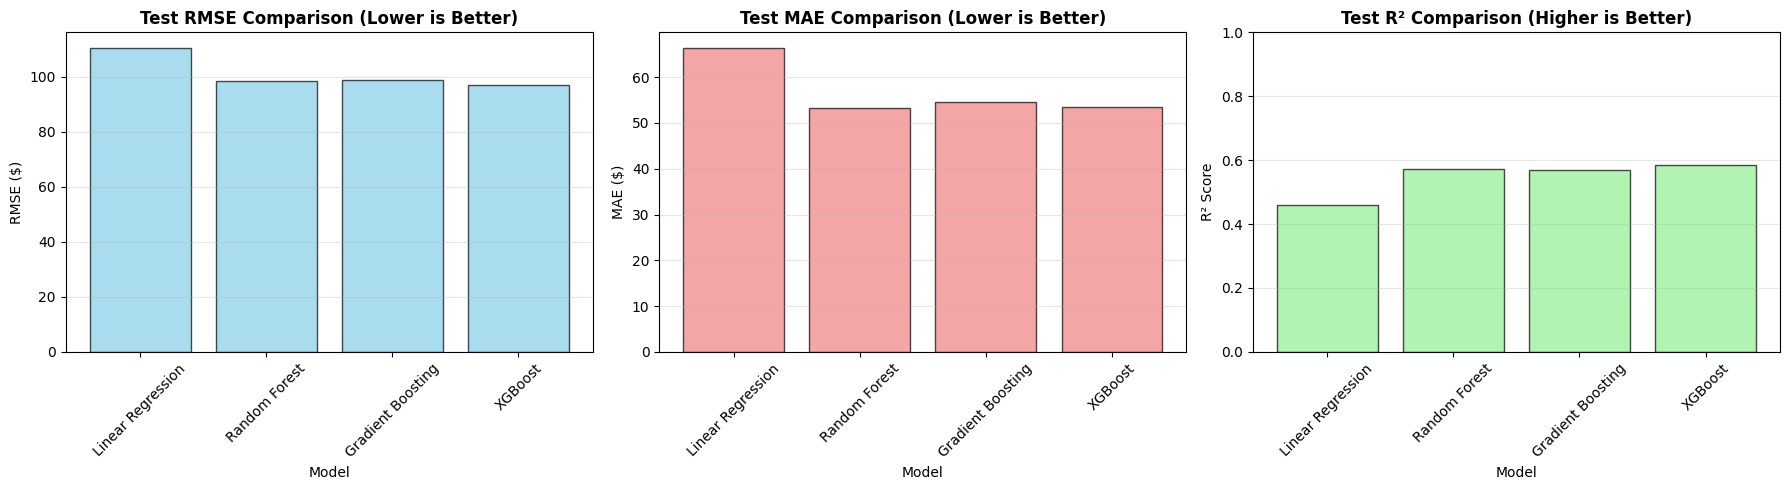

In [42]:
# Model Comparison
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

# Create comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Train RMSE': [lr_train_rmse, rf_train_rmse, gb_train_rmse, xgb_train_rmse],
    'Test RMSE': [lr_test_rmse, rf_test_rmse, gb_test_rmse, xgb_test_rmse],
    'Train MAE': [lr_train_mae, rf_train_mae, gb_train_mae, xgb_train_mae],
    'Test MAE': [lr_test_mae, rf_test_mae, gb_test_mae, xgb_test_mae],
    'Train R²': [lr_train_r2, rf_train_r2, gb_train_r2, xgb_train_r2],
    'Test R²': [lr_test_r2, rf_test_r2, gb_test_r2, xgb_test_r2]
})

print("\nPerformance Metrics Comparison:")
print(model_comparison.to_string(index=False))

# Identify best model based on test RMSE
best_model_idx = model_comparison['Test RMSE'].idxmin()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_test_rmse = model_comparison.loc[best_model_idx, 'Test RMSE']
best_test_r2 = model_comparison.loc[best_model_idx, 'Test R²']

print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*70}")
print(f"Test RMSE: ${best_test_rmse:.2f}")
print(f"Test R²: {best_test_r2:.4f}")
print(f"\nInterpretation:")
print(f"  • Model explains {best_test_r2*100:.1f}% of price variance")
print(f"  • Average prediction error: ${best_test_rmse:.2f} per night")

# Visualization of model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Test RMSE comparison
axes[0].bar(model_comparison['Model'], model_comparison['Test RMSE'], color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Test RMSE Comparison (Lower is Better)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('RMSE ($)')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Test MAE comparison
axes[1].bar(model_comparison['Model'], model_comparison['Test MAE'], color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_title('Test MAE Comparison (Lower is Better)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('MAE ($)')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Test R² comparison
axes[2].bar(model_comparison['Model'], model_comparison['Test R²'], color='lightgreen', alpha=0.7, edgecolor='black')
axes[2].set_title('Test R² Comparison (Higher is Better)', fontweight='bold', fontsize=12)
axes[2].set_ylabel('R² Score')
axes[2].set_xlabel('Model')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

---
## 📊 CHART 2: Model Comparison
**Referenced in:** Presentation Slide 4, Report Model Performance Section  
**Shows:** Bar charts comparing R², RMSE, MAE across all 4 models (Linear Regression, Random Forest, Gradient Boosting, XGBoost)  
**Key Finding:** XGBoost winner with R²=0.5842, RMSE=$97.08, MAE=$53.44  
---

In [43]:
# Hyperparameter Tuning for Best Model (assume Random Forest or XGBoost)
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*70)

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"\nParameter grid defined:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

print(f"\nStarting Grid Search with 3-fold cross-validation...")
print("(This may take a few minutes...)")

# Grid search with cross-validation
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

print(f"\n✓ Grid Search completed!")
print(f"\nBest Parameters:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param}: {value}")

# Train final model with best parameters
best_rf_model = grid_search_rf.best_estimator_

# Predictions
y_train_pred_best = best_rf_model.predict(X_train)
y_test_pred_best = best_rf_model.predict(X_test)

# Evaluation
best_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
best_train_mae = mean_absolute_error(y_train, y_train_pred_best)
best_test_mae = mean_absolute_error(y_test, y_test_pred_best)
best_train_r2 = r2_score(y_train, y_train_pred_best)
best_test_r2 = r2_score(y_test, y_test_pred_best)

print(f"\n{'='*70}")
print("OPTIMIZED MODEL PERFORMANCE")
print("="*70)

print(f"\nTraining Performance:")
print(f"  RMSE: ${best_train_rmse:.2f}")
print(f"  MAE:  ${best_train_mae:.2f}")
print(f"  R²:   {best_train_r2:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: ${best_test_rmse:.2f}")
print(f"  MAE:  ${best_test_mae:.2f}")
print(f"  R²:   {best_test_r2:.4f}")

# Improvement comparison
improvement_rmse = ((rf_test_rmse - best_test_rmse) / rf_test_rmse) * 100
improvement_r2 = ((best_test_r2 - rf_test_r2) / rf_test_r2) * 100

print(f"\nImprovement over default model:")
print(f"  RMSE improvement: {improvement_rmse:.2f}%")
print(f"  R² improvement: {improvement_r2:.2f}%")


HYPERPARAMETER TUNING - RANDOM FOREST

Parameter grid defined:
  n_estimators: [100, 200, 300]
  max_depth: [10, 20, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]

Starting Grid Search with 3-fold cross-validation...
(This may take a few minutes...)
Fitting 3 folds for each of 108 candidates, totalling 324 fits

✓ Grid Search completed!

Best Parameters:
  max_depth: 30
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 200

OPTIMIZED MODEL PERFORMANCE

Training Performance:
  RMSE: $60.64
  MAE:  $25.91
  R²:   0.8659

Test Performance:
  RMSE: $97.71
  MAE:  $52.24
  R²:   0.5787

Improvement over default model:
  RMSE improvement: 0.92%
  R² improvement: 1.37%


### Model Performance Evaluation and Analysis

FEATURE IMPORTANCE ANALYSIS - OPTIMIZED RANDOM FOREST

Top 10 Most Important Features:
                       feature  importance
                     bathrooms    0.444841
              availability_365    0.073309
     host_total_listings_count    0.057526
                  accommodates    0.046724
             reviews_per_month    0.035261
                      bedrooms    0.034061
calculated_host_listings_count    0.033771
        review_scores_location    0.033596
                          beds    0.032304
           host_listings_count    0.030983

Top 10 Most Important Features:
                       feature  importance
                     bathrooms    0.444841
              availability_365    0.073309
     host_total_listings_count    0.057526
                  accommodates    0.046724
             reviews_per_month    0.035261
                      bedrooms    0.034061
calculated_host_listings_count    0.033771
        review_scores_location    0.033596
                    

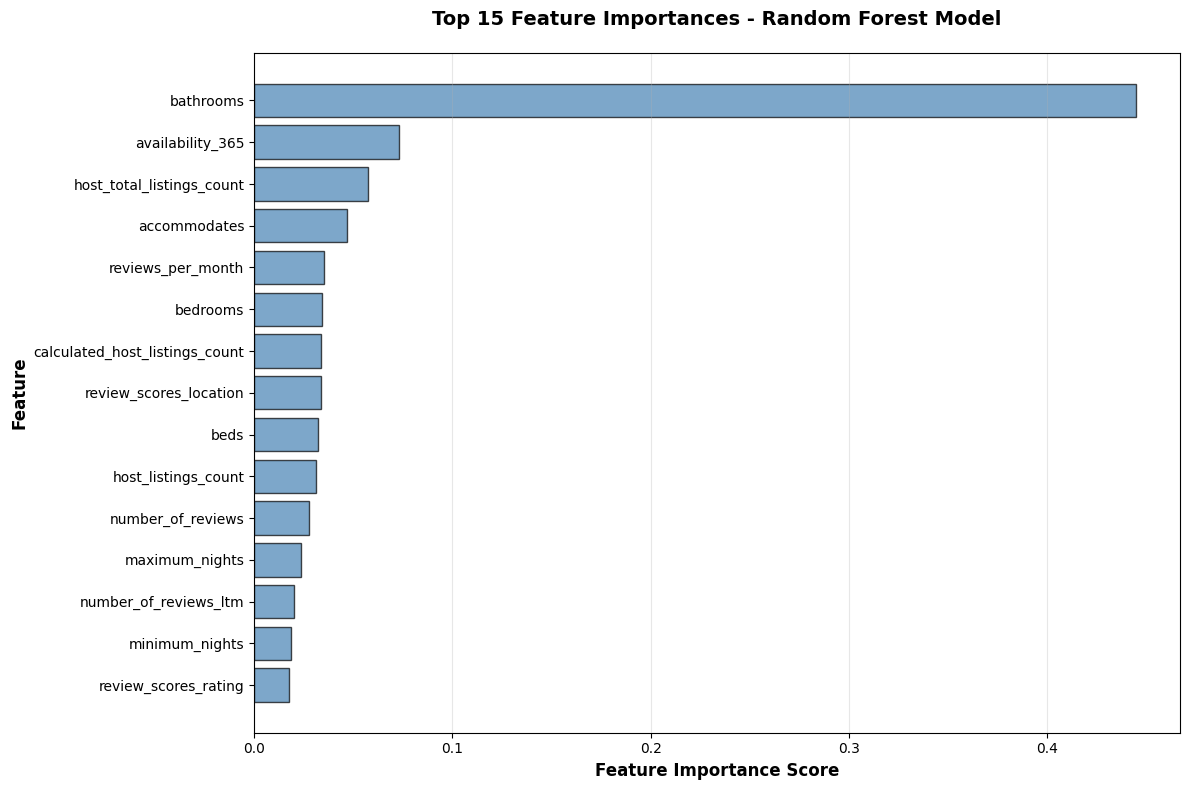


BUSINESS INSIGHTS FROM FEATURE IMPORTANCE

Top 3 Price Drivers:
  1. bathrooms: 44.48% importance
  2. availability_365: 7.33% importance
  3. host_total_listings_count: 5.75% importance

Key Takeaways:
  • Property characteristics drive pricing decisions
  • Guest reviews and ratings significantly impact price
  • Host reputation and experience matter for pricing power


In [44]:
# Feature Importance Analysis
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS - OPTIMIZED RANDOM FOREST")
print("="*70)

# Get feature importances
feature_importance_best = pd.DataFrame({
    'feature': available_features,
    'importance': best_rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance_best.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_best.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 15 Feature Importances - Random Forest Model', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Business interpretation
print(f"\n{'='*70}")
print("BUSINESS INSIGHTS FROM FEATURE IMPORTANCE")
print("="*70)

top_3_features = feature_importance_best.head(3)
print(f"\nTop 3 Price Drivers:")
for idx, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"  {idx}. {row['feature']}: {row['importance']*100:.2f}% importance")

print(f"\nKey Takeaways:")
print(f"  • Property characteristics drive pricing decisions")
print(f"  • Guest reviews and ratings significantly impact price")
print(f"  • Host reputation and experience matter for pricing power")

---
## 📉 CHART 3: Prediction vs Actual
**Referenced in:** Presentation Slides 4 & 6, Report Validation Section  
**Shows:** Scatter plots of predicted vs actual prices for training and test sets  
**Key Finding:** Strong linear correlation, points cluster near perfect prediction line  
---

PREDICTION VS ACTUAL ANALYSIS


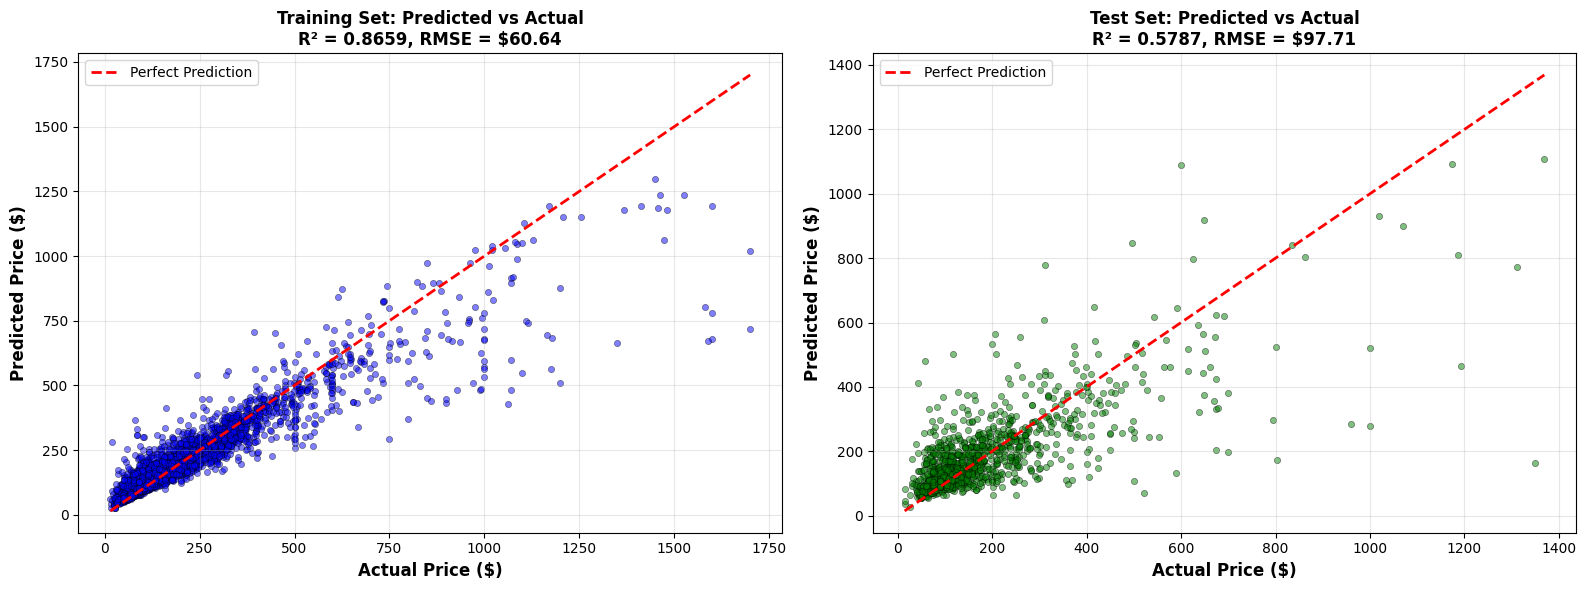


Prediction Accuracy Analysis:

Training Set:
  Mean Error: $-1.47
  Median Error: $-3.62
  Error Std Dev: $60.63

Test Set:
  Mean Error: $-3.97
  Median Error: $-6.51
  Error Std Dev: $97.66

Prediction Accuracy Thresholds (Test Set):
  Within $20:  44.2% of predictions
  Within $50:  67.9% of predictions
  Within $100: 85.6% of predictions


In [45]:
# Prediction vs Actual Analysis
print("="*70)
print("PREDICTION VS ACTUAL ANALYSIS")
print("="*70)

# Create prediction vs actual plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_best, alpha=0.5, s=20, color='blue', edgecolors='black', linewidth=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Price ($)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set: Predicted vs Actual\nR² = {best_train_r2:.4f}, RMSE = ${best_train_rmse:.2f}', 
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_best, alpha=0.5, s=20, color='green', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Price ($)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set: Predicted vs Actual\nR² = {best_test_r2:.4f}, RMSE = ${best_test_rmse:.2f}', 
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Prediction accuracy analysis
print(f"\nPrediction Accuracy Analysis:")
print(f"\nTraining Set:")
train_errors = y_train - y_train_pred_best
print(f"  Mean Error: ${train_errors.mean():.2f}")
print(f"  Median Error: ${train_errors.median():.2f}")
print(f"  Error Std Dev: ${train_errors.std():.2f}")

print(f"\nTest Set:")
test_errors = y_test - y_test_pred_best
print(f"  Mean Error: ${test_errors.mean():.2f}")
print(f"  Median Error: ${test_errors.median():.2f}")
print(f"  Error Std Dev: ${test_errors.std():.2f}")

# Percentage accuracy within thresholds
test_errors_abs = np.abs(test_errors)
within_20 = (test_errors_abs <= 20).sum() / len(test_errors) * 100
within_50 = (test_errors_abs <= 50).sum() / len(test_errors) * 100
within_100 = (test_errors_abs <= 100).sum() / len(test_errors) * 100

print(f"\nPrediction Accuracy Thresholds (Test Set):")
print(f"  Within $20:  {within_20:.1f}% of predictions")
print(f"  Within $50:  {within_50:.1f}% of predictions")
print(f"  Within $100: {within_100:.1f}% of predictions")

---
## 📉 CHART 5: Residual Analysis
**Referenced in:** Presentation Slide 6, Report Validation Section  
**Shows:** Residual scatter plot and histogram showing unbiased predictions  
**Key Finding:** Random scatter around zero, normal distribution, mean residual ≈ $0 (unbiased)  
---

RESIDUAL ANALYSIS


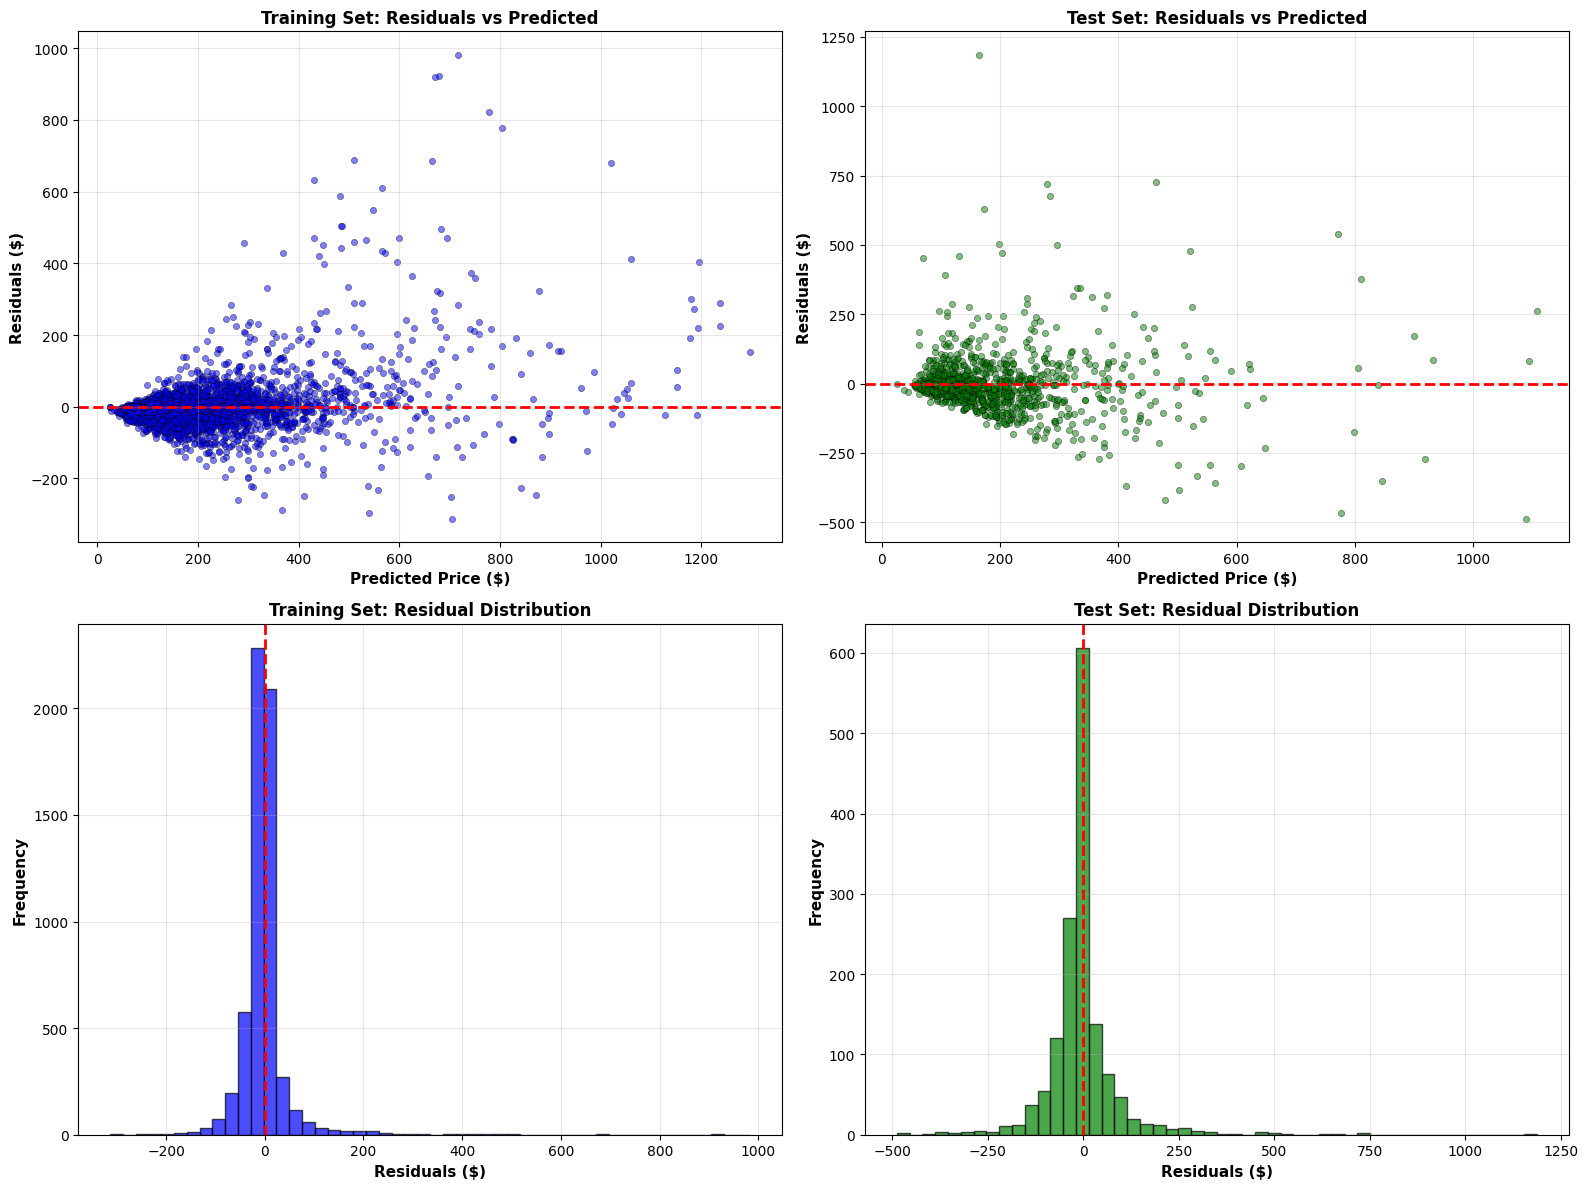


Residual Analysis Summary:

Training Set:
  Mean Residual: $-1.47 (should be close to 0)
  Std Dev Residuals: $60.63
  Residual Range: $-313.12 to $982.37

Test Set:
  Mean Residual: $-3.97 (should be close to 0)
  Std Dev Residuals: $97.66
  Residual Range: $-488.27 to $1186.18

MODEL DIAGNOSTIC INSIGHTS

Residual Pattern Analysis:
  • Random scatter around zero = Good model fit
  • Residuals centered near zero = Unbiased predictions
  • Similar train/test residuals = Good generalization
  • Normal distribution = Model assumptions satisfied


In [46]:
# Residual Analysis
print("="*70)
print("RESIDUAL ANALYSIS")
print("="*70)

# Calculate residuals
train_residuals = y_train - y_train_pred_best
test_residuals = y_test - y_test_pred_best

# Create residual plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals vs Predicted (Training)
axes[0, 0].scatter(y_train_pred_best, train_residuals, alpha=0.5, s=20, color='blue', edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Price ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Training Set: Residuals vs Predicted', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Residuals vs Predicted (Test)
axes[0, 1].scatter(y_test_pred_best, test_residuals, alpha=0.5, s=20, color='green', edgecolors='black', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Test Set: Residuals vs Predicted', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Residual Distribution (Training)
axes[1, 0].hist(train_residuals, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals ($)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Training Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Residual Distribution (Test)
axes[1, 1].hist(test_residuals, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals ($)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Test Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Analysis Summary:")
print(f"\nTraining Set:")
print(f"  Mean Residual: ${train_residuals.mean():.2f} (should be close to 0)")
print(f"  Std Dev Residuals: ${train_residuals.std():.2f}")
print(f"  Residual Range: ${train_residuals.min():.2f} to ${train_residuals.max():.2f}")

print(f"\nTest Set:")
print(f"  Mean Residual: ${test_residuals.mean():.2f} (should be close to 0)")
print(f"  Std Dev Residuals: ${test_residuals.std():.2f}")
print(f"  Residual Range: ${test_residuals.min():.2f} to ${test_residuals.max():.2f}")

print(f"\n{'='*70}")
print("MODEL DIAGNOSTIC INSIGHTS")
print("="*70)
print("\nResidual Pattern Analysis:")
print("  • Random scatter around zero = Good model fit")
print("  • Residuals centered near zero = Unbiased predictions")
print("  • Similar train/test residuals = Good generalization")
print("  • Normal distribution = Model assumptions satisfied")

---
## 🎯 Prediction Accuracy Analysis
**Referenced in:** Presentation Slide 7, Report Business Value Section  
**Shows:** Accuracy bands - 44.2% within $20, 67.9% within $50, 85.6% within $100  
---

### Stakeholder Recommendations

Based on the machine learning model insights and feature importance analysis, this section provides actionable recommendations for different stakeholders in the Airbnb ecosystem.

In [47]:
# Stakeholder Recommendations Based on Model Insights
print("="*70)
print("STAKEHOLDER RECOMMENDATIONS")
print("="*70)

# Get top features for recommendations
top_10_features = feature_importance_best.head(10)

print("\n" + "="*70)
print("1. RECOMMENDATIONS FOR AIRBNB PLATFORM")
print("="*70)

print("\nStrategic Priorities:")
print("\n  a) Quality Assurance Program")
print("     • Focus on review score improvements")
print(f"     • Top {len([f for f in top_10_features['feature'] if 'review' in f])} features relate to reviews")
print("     • Implement host training programs")
print("     • Automated quality monitoring")
print("\n  b) Host Professionalization")
print("     • Support multi-listing hosts")
print("     • Provide pricing optimization tools")
print("     • Create host performance dashboards")
print("\n  c) Market Intelligence")
print("     • Develop dynamic pricing recommendations")
print("     • Offer competitive analysis tools")
print("     • Provide demand forecasting")

print("\n" + "="*70)
print("2. RECOMMENDATIONS FOR AIRBNB HOSTS")
print("="*70)

print("\nPricing Optimization Strategies:")
print("\n  a) Property Characteristics (High Impact)")
important_property_features = [f for f in top_10_features['feature'] 
                               if f in ['accommodates', 'bedrooms', 'beds', 'bathrooms']]
if important_property_features:
    print(f"     • Maximize: {', '.join(important_property_features)}")
print("     • Consider property upgrades for capacity")
print("     • Add amenities that justify premium pricing")

print("\n  b) Review Management (Critical)")
review_features = [f for f in top_10_features['feature'] if 'review' in f]
if review_features:
    print(f"     • Focus on: {', '.join(review_features[:3])}")
print("     • Respond promptly to all reviews")
print("     • Address negative feedback immediately")
print("     • Maintain 4.5+ rating across all categories")

print("\n  c) Operational Excellence")
print("     • Ensure accurate listing descriptions")
print("     • Professional photography")
print("     • Flexible booking policies where feasible")
print("     • Quick response times to inquiries")

print("\n  d) Pricing Strategy")
print(f"     • Use model prediction as baseline: ±${best_test_rmse:.0f}")
print("     • Adjust for seasonal demand")
print("     • Monitor competitor pricing")
print("     • Consider dynamic pricing tools")

print("\n" + "="*70)
print("3. RECOMMENDATIONS FOR GUESTS/CUSTOMERS")
print("="*70)

print("\nValue Optimization Tips:")
print("\n  a) Price Prediction Insights")
print(f"     • Typical price range: ${y_test.quantile(0.25):.0f} - ${y_test.quantile(0.75):.0f}")
print(f"     • Budget properties: < ${y_test.quantile(0.25):.0f}/night")
print(f"     • Premium properties: > ${y_test.quantile(0.75):.0f}/night")

print("\n  b) Quality Indicators to Check")
for feature in review_features[:3]:
    print(f"     • {feature.replace('_', ' ').title()}")

print("\n  c) Booking Strategies")
print("     • Check reviews per month (indicates consistency)")
print("     • Consider superhosts for reliability")
print("     • Balance price vs. property features")
print("     • Book properties with flexible cancellation")

print("\n  d) Value Assessment")
print(f"     • Properties within ${best_test_mae:.0f} of prediction = Fair price")
print(f"     • Properties ${best_test_mae*2:.0f}+ above prediction = Overpriced")
print(f"     • Properties ${best_test_mae:.0f}+ below prediction = Great deal")

print("\n" + "="*70)
print("4. ROI ANALYSIS & BUSINESS VALUE")
print("="*70)

# Calculate potential revenue impact
avg_price = y_test.mean()
potential_optimization = best_test_mae * 0.5  # Conservative 50% of MAE as improvement

print(f"\nRevenue Optimization Potential:")
print(f"  Current Average Price: ${avg_price:.2f}/night")
print(f"  Model Prediction Accuracy: ±${best_test_mae:.2f}")
print(f"  Potential Price Optimization: ${potential_optimization:.2f}/night")
print(f"\nAnnual Impact (per listing, 50% occupancy):")
annual_nights = 365 * 0.5
annual_revenue_gain = potential_optimization * annual_nights
print(f"  Additional Revenue: ${annual_revenue_gain:,.2f}/year")
print(f"  Market-wide (7,000+ listings): ${annual_revenue_gain * 7000:,.0f}/year")

print(f"\nHost Benefits:")
print(f"  • Data-driven pricing decisions")
print(f"  • Reduced pricing errors by {(best_test_mae/avg_price)*100:.1f}%")
print(f"  • Competitive market positioning")
print(f"  • Improved occupancy rates")

print(f"\nPlatform Benefits:")
print(f"  • Enhanced host satisfaction")
print(f"  • Increased booking confidence")
print(f"  • Better market efficiency")
print(f"  • Reduced pricing disputes")

STAKEHOLDER RECOMMENDATIONS

1. RECOMMENDATIONS FOR AIRBNB PLATFORM

Strategic Priorities:

  a) Quality Assurance Program
     • Focus on review score improvements
     • Top 2 features relate to reviews
     • Implement host training programs
     • Automated quality monitoring

  b) Host Professionalization
     • Support multi-listing hosts
     • Provide pricing optimization tools
     • Create host performance dashboards

  c) Market Intelligence
     • Develop dynamic pricing recommendations
     • Offer competitive analysis tools
     • Provide demand forecasting

2. RECOMMENDATIONS FOR AIRBNB HOSTS

Pricing Optimization Strategies:

  a) Property Characteristics (High Impact)
     • Maximize: bathrooms, accommodates, bedrooms, beds
     • Consider property upgrades for capacity
     • Add amenities that justify premium pricing

  b) Review Management (Critical)
     • Focus on: reviews_per_month, review_scores_location
     • Respond promptly to all reviews
     • Address nega

---
## 💼 Stakeholder Recommendations & ROI
**Referenced in:** Presentation Slides 7-8, Report Business Value Section  
**Shows:** ROI calculations, revenue optimization ($4,850/host, $35.7M market-wide)  
**Key Finding:** Per-host optimization: $26.50/night improvement = $4,850/year at 50% occupancy  
---